In [2]:
import numpy as np
import scipy
import random
import pandas as pd
import pickle
import seaborn.objects as so
import hashlib
import matplotlib.pyplot as plt


import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats   

from IPython.display import display, HTML

# Functions

### Containerclass for standard operations on metrics

In [202]:
class MetricManager:
    def __init__(self, metrics):
        """
        Inits the MetricManager

        Variables:
         - metrics: list of all metrics in form of a list of single runs
         - runs: parameters for the single runs extracted from the complete metrics
        """
        self.metrics = metrics

        self.runs = pd.DataFrame(metrics).drop(["expert metrics", "verma", "hemmer"], axis=1)

        self.l2d_dfs = {
            "verma": {},
            "hemmer": {}
        }

        self.metric_dfs= {
            "verma": {},
            "hemmer": {}
        }

    def get_dataframe_specific_run(self, run, method, seed, fold, step):
        """
        Returns a DataFrame for a given method of one (run, seed, fold) combination
        Step specifies the evaluation step (val, test)
        """
        if method == "verma":
            return self.create_dataframe_verma(run, seed, fold, step)
        if method == "hemmer":
            return self.create_dataframe_hemmer(run, seed, fold, step)

    def create_dataframe_verma(self, run, seed, fold, step):
        """
        Creates a dataframe which contains all metrics for verma for a given run, seed, fold and step

        Result is a DataFrame with every metric for the (run, seed, fold) combination
        """
        #Drops redundant columns
        df = pd.DataFrame(self.metrics[run]["verma"][seed][fold][step]).drop(["acc_experts", "cov_experts"], axis=0).T
        #Extract the number of images from coverage text
        df["coverage"] = df["coverage"].apply(lambda x: getCountOfCoverage(x))
        #df.rename(columns={'coverage':'n_images'}, inplace=True)
        return df

    def create_dataframe_hemmer(self, run, seed, fold, step):
        """
        Creates a dataframe which contains all metrics for hemmer for a given run, seed, fold and step

        Result is a DataFrame with every metric for the (run, seed, fold) combination
        """
        df = pd.DataFrame(self.metrics[run]["hemmer"][seed][fold][step]).T
        #Get the absolute number of images from the same combination from verma
        n_images = getCountOfCoverage(self.metrics[run]["verma"][seed][fold][step][0]["coverage"])
        #Extracts the experts ids
        experts = [column[7:] for column in df.columns if "Expert" in column]
        #Converts the percentage of coverage to absolute number
        df["Classifier Coverage"] = n_images * df["Classifier Coverage"]
        df["system_accuracy"] = df["system_accuracy"] * 100
        #Create metrics for every expert from list elements
        for expert in experts:
            df[f"{expert} Accuracy"] = [row["expert_accuracy"] for row in df[f"Expert_{expert}"]]
            df[f"{expert} Subset Accuracy"] = [row["expert_task_subset_accuracy"] for row in df[f"Expert_{expert}"]]
            df[f"{expert} Coverage"] = [n_images * row["expert_coverage"] for row in df[f"Expert_{expert}"]]
            df = df.drop([f"Expert_{expert}"], axis=1)
        return df

    def create_l2d_dataframe(self, method, step):
        """
        Creates a multiindex dataframe which contains all metrics for a L2D method and given step

        Result is a multiindex df (run, seed, fold)
        """
        dict_run = {}
        #Iterate over all runs
        for run in range(len(self.metrics)):
            dict_seed = {}
            #Iterate over all seeds
            for seed, val1 in self.metrics[run][method].items():
                dict_fold = {}
                #Iterate over every fold
                for fold, element in self.metrics[run][method][seed].items():
                    #Add metric for this (run, seed, fold) combination to the fold_dict
                    dict_fold[f"Fold_{fold}"] = self.get_dataframe_specific_run(run, method, seed, fold, step)
                #Create DataFrame for all folds in this (run, seed) combination
                df_seed = pd.concat(dict_fold)
                dict_seed[f"Seed_{seed}"] = df_seed
            #Create DataFrame for all seeds in this run
            df_run = pd.concat(dict_seed)
            dict_run[f"Run_{run}"] = df_run
        #Create DataFrame for all runs
        df_test = pd.concat(dict_run)
        return df_test

    def get_l2d_dataframe(self, method, step):
        """
        Returns the needed df

        Stores created dfs to speed up the process
        """
        if step not in self.l2d_dfs[method]:
            self.l2d_dfs[method][step] = self.create_l2d_dataframe(method, step)
        return self.l2d_dfs[method][step]

    def create_metric_dataframe(self, df, metric_name, method):
        """
        Creates the df for a L2D method and a specified aggregation method

        It chooses the metric from the single training step where the model had the best validation accuracy

        Current implemented are max for the aggregation of a (run, seed, fold) combination
        """
        #Only get the wanted metric
        dff = df[[metric_name]]

        #Get the indices where the model had the best validation accuracy
        #Matrix in form of columns=runs, rows=(seed + fold) (row index is range(len(seeds, folds combinations))
        indices = self.get_best_model_indices(method)

        #Get the indices for the complete dataframe (multiindex) in formate (run, seed, fold)
        index = dff.index
        #Get list of unique runs
        index_runs = index.get_level_values(0).drop_duplicates()
        #index_seeds = index.get_level_values(1).drop_duplicates()
        #index_folds = index.get_level_values(2).drop_duplicates()

        values = {}
        run_count = 0
        #Iterrate over all runs
        for run in index_runs:
            run_list = []
            count = 0
            #Get list of unique seeds in the current run
            index_seeds = dff.loc[run].index.get_level_values(0).drop_duplicates()
            #Iterrate over all seeds in the current run
            for seed in index_seeds:
                #Get list of qunique folds in the current run
                index_folds = dff.loc[(run, seed)].index.get_level_values(0).drop_duplicates()
                #Itterate over every fold in the current (run, seed) combination
                for fold in index_folds:
                    #Append the value from the current (run, seed, fold) combination on position indices.iloc[count, run_count] 
                    # (which is the training step from (run, seed, fold) where the model had the best val accuracy
                    run_list.append(dff.loc[(run, seed, fold, indices.iloc[count, run_count])][0])
                    #increases the parameter for index selection
                    count += 1
                values[run] = run_list
            run_count += 1
        #return pd.DataFrame(values)
        return pd.DataFrame(dict([(key, pd.Series(item)) for key, item in values.items()]))

    def get_best_model_indices(self, method):
        """
        Creates a df which contains the training step for every (run, seed, fold) combination in which the model had the best validation accuracy

        Returns a df the form of columns=runs, rows=range(len(seed - fold combinations in this run))
        """
        df = self.get_l2d_dataframe(method, "val") #Get metrics for every run, seed, fold
        dff = df[["system_accuracy"]]
        index = dff.index
        index_runs = index.get_level_values(0).drop_duplicates()

        #Iterrate ofer the complete multiindex df of system accuracy
        values = {}
        for run in index_runs:
            run_list = []
            index_seeds = dff.loc[run].index.get_level_values(0).drop_duplicates()
            for seed in index_seeds:
                index_folds = dff.loc[(run, seed)].index.get_level_values(0).drop_duplicates()
                for fold in index_folds:
                    #Get the index of the step of this (run, seed, fold) combination where the system accuracy is max
                    run_list.append(pd.to_numeric(dff.loc[(run, seed, fold), "system_accuracy"]).idxmax())
            values[run] = run_list
        #Returns df
        return pd.DataFrame(dict([(key, pd.Series(item)) for key, item in values.items()]))

    def get_metric_dataframe(self, method, step, metric_name):
        """
        Returns a dataframe for one metric

        Columns are runs, rows are the max of the L2D systems metric for every fold
        """
        df = self.get_l2d_dataframe(method, step) #Get metrics for every run, seed, fold

        if step not in self.metric_dfs[method]:
            self.metric_dfs[method][step] = {}
        if metric_name not in self.metric_dfs[method][step]:
            self.metric_dfs[method][step][metric_name] = self.create_metric_dataframe(df, metric_name, method)

        return self.metric_dfs[method][step][metric_name].copy()

    def get_metrics_dataframe_cut(self, method, step, metric_name, unwanted_tuple=None):
        """
        Cuts the name and add the posibility to remove unwanted parameter-value pairs
        """
        df = cut_column_name(self.get_metric_dataframe(method, step, metric_name))
        columns = df.columns
        if unwanted_tuple is not None: # Get only indieces of runs without unwanted parameter-value pairs
            columns = [str(el) for el in list(remove_unwanted_runs(self.runs, unwanted_tuple).index)]
        return df.loc[:,columns] #Return metric for every run with applied method to aggregate seeds and folds
        

    def print_metrics(self, df):
        """
        Prints the columns of a drataframe to get all available metrics
        """
        print(df.columns)

### Standard utils

In [ ]:
def getCountOfCoverage(text):
    """
    Returns the number of images from the verma-metric coverage text
    """
    marker = None
    for j in range(len(text)):
        if text[-j] == "f":
            marker = j -1
    return int(text[-marker:])

def cut_column_name(df):
    """
    Removes the run_ prefix for every column
    """
    columns = [column[4:] for column in df.columns]
    df.columns = columns
    return df

def runs_cost_to_string(df):
    df = df.copy()
    if "cost" in df.columns:
        df["cost"] = df["cost"].apply(lambda x: cost_to_string(x))
    return df

def cost_to_string(cost):
    return str(cost)

def remove_unwanted_runs(df, unwanted_tuples):
    """
    Removes runs which contains unwanted column-value combinations

    Input:
        df - DataFrame which contains all runs
        unwanted_tuples - List of (column, value) pairs which should be removed
    """
    if isinstance(unwanted_tuples, tuple): #Make sure a single tuple doesn't break the code
        unwanted_tuples = [unwanted_tuples]
    dff = df.copy()
    for pair in unwanted_tuples:
        if (pair[0] in dff.columns): #Check if the column exists in the DataFrame
            dff = dff[dff[pair[0]] != pair[1]]
    return dff

### t-Test Functions

In [158]:
def check_all_ttest(df, p=0.05, equal_var=False, plot=False):
    """
    Checks all columns of the dataframe of statistical significance
    """
    matrix = {}
    for i in df.columns:
        row = {}
        for j in df.columns:
            if i == j:
                row[j] = 1
            else:
                res = get_ttest(df.loc[:,[i]], df.loc[:,[j]], equal_var=equal_var)
                row[j] = res.pvalue[0]
        matrix[i] = row

    if plot:
        df = pd.DataFrame(matrix)
        heat = plot_ttests(df)
        return matrix, heat
    return matrix

def get_ttest(value1, value2, equal_var=True):
    res = ttest_ind(value1, value2, equal_var=equal_var, nan_policy="omit")
    #print(res)
    return res

def plot_ttests(df):
    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(25, 11))
    heat = sns.heatmap(df, annot=True, linewidths=.5, ax=ax)
    plt.show()
    return heat

# Class for group functions

In [ ]:
class Grouped:
    def __init__(self, metric_manager):
        self.metric_manager = metric_manager

    

## Functions to group runs

In [238]:
def get_rungroup_name(df_runs, runs_g, var_columns, reverse=False):
    """
    Create names for every run where the runs differentiate in parameters

    Input:
        df_runs: DataFrame with every run and its parameters
        runs_g: Group of runs in structure [[0, 1, 2], [3, 4]]
        var_columns: Names of columns which can vary in a aggregated run
        reverse: If all columns could vary except of the given ones

    Return:
        run_names: Names for every run
        keys: Columnnames in which the runs are different
    """
    const_columns = [column for column in df_runs.columns if column not in var_columns]
    if reverse:
        const_columns = var_columns

    group_dict = []
    for run_group in runs_g:
        group_dict.append(dict(df_runs.loc[run_group[0], const_columns]))

    keys = []
    for i in range(len(group_dict) - 1):
        temp_keys = [k for k in group_dict[i] if group_dict[i][k] != group_dict[i + 1][k]]
        for key in temp_keys:
            if key not in keys:
                keys.append(key)
    keys.reverse()

    run_names = []
    for run_group in runs_g:
        run_names.append(create_run_name_from_columns(df_runs.loc[run_group[0]], keys))

    return run_names, keys

def create_run_name_from_columns(run, columns):
    """
    Concats names of columns with value for one run

    Input:
        run: DataFrame which contains one run with its parameters
        columns: The columns to build the name

    Return:
        Concated string from column-value pairs
    """
    name = ""
    #columns.reverse()
    for column in columns:
        name = name + f"{column}_{run.loc[column]}_"
    return name[:-1]


def get_runs_grouped(df, var_columns, reverse=False):
    """
    Groups the runs by their parameters
    All parameters except the passed ones are equal

    Returns a list whichs elements are lists of equal runs like [[0, 1, 2], [3, 4, 5]]
    """
    #Gets the columns which defines a aggregated run (stay constant for on aggregation)
    const_columns = [column for column in df.columns if column not in var_columns]
    #If all columns should be variable except the given ones
    if reverse:
        const_columns = var_columns

    pairs = []
    referenc_row = None
    index_list = list(df.index)
    #For every run in the dataframe
    for index in df.index:
        #If the run already is aggregated into one group
        if index in [el for sublist in pairs for el in sublist]:
            continue
        #Remove index to prevent adding it into the group to himself
        index_list.remove(index)
        #Get the reference row with the conctant columns
        referenc_row = df.loc[index, const_columns].to_dict()
        pair = [index]
        #Look at all other runs
        for index_j in index_list:
            current_row = df.loc[index_j, const_columns].to_dict()
            #If the current row equals the reference  row in the constant columns
            if referenc_row == current_row:
                pair.append(index_j)
        #Removed aggregated rows to prevent aggregation into different groups
        for el in pair:
            if el in index_list:
                index_list.remove(el)
        pairs.append(pair)
    return pairs

def get_runs_grouped_metric(df_runs, df_metrics, var_columns, reverse=False, unwanted_tuples=None):
    """
    Returns a DataFrame where the runs are aggregated and metrics for are combined for a aggregation

    A Aggregated run contains all metrics for every run it contains
    
    Parameter:
        var_columns are the coulmns which aren't fix, all other are
        Reverse makes all columns variable except var_columns

    Return:
        df - The DataFrame which contains aggregated runs with metrics
        df_runs.loc[first_indices, keys] - List of the aggregated runs from df_runs to show the parameters of the aggregated runs
    """

    #Remove unwanted runs
    if unwanted_tuples is not None:
        df_runs = remove_unwanted_runs(df_runs, unwanted_tuples)
    df_runs = runs_cost_to_string(df_runs)
    #Get groups of runs
    g_runs = get_runs_grouped(df_runs, var_columns, reverse)
    df = None
    first_indices = []
    for run_group in g_runs:
        #Append first run of group to show the parameters of a group
        first_indices.append(run_group[0])
        values = []
        #For every run in a group
        for run in run_group:
            #Aggregate the values of every run in this group
            values = values + df_metrics[str(run)].tolist()
        #Create Dataframe with aggregated values
        dff = pd.DataFrame(values, columns=[str(run_group)])
        #If first element of the group create Dataframe
        if df is None:
            df = dff
        else: #Concat for every other run in the group
            df = pd.concat([df, dff], axis=1)

    #keys are the columns of runs where the values are different in the aggregated runs
    #Prevents from printing column-values which are constant over all run groups
    df.columns, keys = get_rungroup_name(df_runs, g_runs, var_columns, reverse)

    df.columns = df_runs.loc[first_indices, keys].index
    
    return df, df_runs.loc[first_indices, keys]

def get_runs_hue_metric(df_runs, df_metrics, var_columns, unwanted_tuples=None):
    """
    Creates a DataFrame in long formate (for seaborn) which groups runs over equal columns and changing var_columns

    Parameter:
        df_runs: DataFrame containing all runs
        df_metrics: DataFrame containing values for one metric over every run and every fold (Columns are runs, rows are the max/var of the L2D systems metric for every fold)
        var_columns: Columns which can vary in a aggregated run
        unwanted_tuples: parameter-value pairs of runs which should be removed
    """
    if unwanted_tuples is not None:
        df_runs = remove_unwanted_runs(df_runs, unwanted_tuples)
    df_runs = runs_cost_to_string(df_runs)
    
    g_runs = get_runs_grouped(df_runs, var_columns, False)

    df = None
    first_indices = []
    dfs = []
    for run_group in g_runs:
        first_indices.append(run_group[0])
        values = {}
        run_dfs = []
        for run in run_group:
            temp_dict = {
                "value": df_metrics[str(run)],
            }
            for column in var_columns:
                temp_dict[column] = [df_runs.loc[run, column] for i in range(len(temp_dict["value"]))]
            df = pd.DataFrame(temp_dict)
            #print(df)
            run_dfs.append(df)
        dff = pd.concat(run_dfs)
        dff["group"] = [run_group[0] for i in range(len(dff))]
        dfs.append(dff)

    _, keys = get_rungroup_name(df_runs, g_runs, var_columns, False)
    
    return pd.concat(dfs), df_runs.loc[first_indices, keys]

def plot_runs_hue_metric(df_runs, df_metrics, var_columns, unwanted_tuples=None, y_text="value", sorted_columns=None):
    df, runs_df = get_runs_hue_metric(df_runs.iloc[:], df_metrics, var_columns, unwanted_tuples)

    f, ax = plt.subplots(figsize=(25, 11))

    display(HTML(runs_df.to_html()))

    #lis = sorted(df[var_columns].apply(tuple, axis=1), key=lambda tup: tup[0])
    lis = df[var_columns].apply(tuple, axis=1)

    g = sns.boxplot(df, y="value", x="group", hue=lis)

    ax.set(xlabel='group', ylabel=y_text)

    series = pd.Series(df[var_columns].apply(tuple, axis=1))
    for i in range(len(var_columns)):
        name = var_columns[i]
        for j, el in enumerate(series):
            el = list(series.iloc[j])
            el[i] = f"{name}: {el[i]}"
            series.iloc[j] = tuple(el)

    if sorted_columns is not None:
        li = list(series.unique())
        sorted_list = sorted(li, key=lambda tup: tuple([tup[idx] for idx in [get_index_from_tuple(tup, name) for name in sorted_columns]]))
    else:
        sorted_list = list(series.unique())

    plt.legend(loc='upper right')
    for t, l in zip(g.legend_.texts, sorted_list):
        t.set_text(l)

    plt.show(g)

    return df, runs_df, lis


def get_index_from_tuple(tuple, name):
    for idx, element in enumerate(tuple):
        if name in element:
            return idx
    return -1


def get_uniq_values(df, column):
    if column in df.columns:
        return set(df[column].values)

def group_ttest(df, plot=False):

    group_test = []
    df = runs_cost_to_string(df)
    for group in get_uniq_values(df, "group"):
        group_df = df[df["group"] == group]

        columns = list(group_df.columns)
        columns.remove("value")
        columns.remove("group")

        dff = group_df.pivot(columns=columns, values='value')

        group_test.append(pd.DataFrame(check_all_ttest(dff)))

    return group_test



## Playground

# Analysis

Load current metrics

In [9]:
#count = 0

#with open(f'Metrics_Folder/Metrics_{count}.pickle', 'wb') as handle:
#    pickle.dump(metrics2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [232]:
def add_perfect(metric, perfect_metric):
    metric.insert(0, perfect_metric)

    metric[0]["init_size"] = 852
    metric[0]["labels_per_round"] = 0
    metric[0]["rounds"] = 0
    metric[0]["labeled"] = 852
    metric[0]["overlap"] = 100

    return metric

In [6]:
import glob

with open("Metrics_Folder/Metrics_98.pickle", 'rb') as handle:
    metrics = pickle.load(handle)

#metricManager = MetricManager(metrics)

In [233]:
import glob

with open("../Metrics_Folder/Metrics_171.pickle", 'rb') as handle:
    metrics2 = pickle.load(handle)

#metrics2.insert(0, metrics[0])

metrics2 = add_perfect(metrics2, metrics[0])

metricManager = MetricManager(metrics2)

df_runs = metricManager.runs

All experiment runs with every parameter combination

All columns

Verma:

In [12]:
metricManager.get_l2d_dataframe("verma", "val").columns

Index(['coverage', 'system_accuracy', 'expert_accuracy', 'classifier_accuracy',
       'alone_classifier', 'validation_loss', 'n_experts', 'expert_0',
       'expert_1', 'expert_0_coverage', 'expert_1_coverage', 'cov_classifier'],
      dtype='object')

Hemmer:

In [104]:
metricManager.get_l2d_dataframe("hemmer", "val").columns

Index(['system_accuracy', 'train_system_loss', 'Classifier Accuracy',
       'Classifier Task Subset Accuracy', 'Classifier Coverage',
       '4323195249 Accuracy', '4323195249 Subset Accuracy',
       '4323195249 Coverage', '4295232296 Accuracy',
       '4295232296 Subset Accuracy', '4295232296 Coverage'],
      dtype='object')

#### Plot single runs

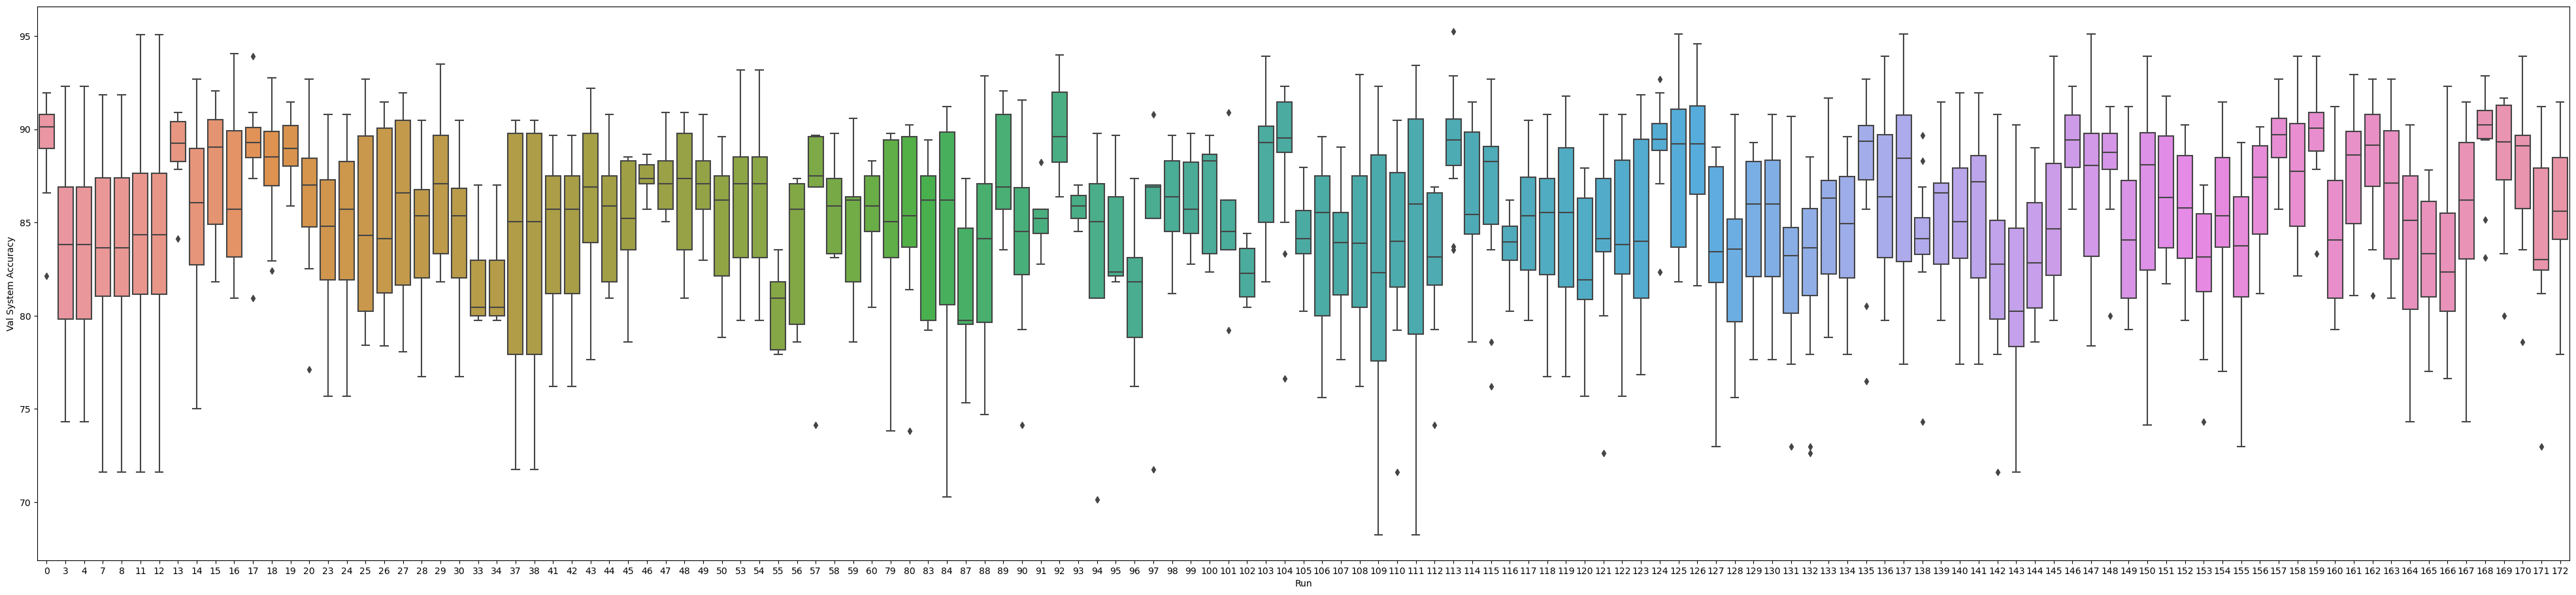

labeler_ids  init_size  labels_per_round  rounds  labeled  \
0    [4323195249, 4295232296]          0                 4       8       32   
3    [4323195249, 4295232296]          4                 4       2       12   
4    [4323195249, 4295232296]          4                 4       2       12   
7    [4323195249, 4295232296]          4                 4       2       12   
8    [4323195249, 4295232296]          4                 4       2       12   
..                        ...        ...               ...     ...      ...   
168  [4323195249, 4295232296]          8                 8       4       40   
169  [4323195249, 4295232296]          8                 8       4       40   
170  [4323195249, 4295232296]          8                 8       4       40   
171  [4323195249, 4295232296]          8                 8       4       40   
172  [4323195249, 4295232296]          8                 8       4       40   

       cost  overlap     setting                mod expert_predict  \
0    (0, 0)        5     PERFECT            perfect         target   
3    (0, 0)        0          AL         confidence         target   
4    (0, 0)        0          AL         confidence         target   
7    (0, 0)        0          AL       disagreement         target   
8    (0, 0)        0          AL       disagreement         target   
..      ...      ...         ...                ...            ...   
168  (0, 0)        0      SSL_AL         confidence         target   
169  (0, 0)        0      SSL_AL       disagreement         target   
170  (0, 0)        0      SSL_AL  disagreement_diff         target   
171  (0, 0)        0      NORMAL             normal         target   
172  (0, 0)        0  SSL_AL_SSL         confidence         target   

     sample_equal  epochs_pretrain  
0           False                0  
3           False                0  
4            True                0  
7           False                0  
8            True                0  
..            ...              ...  
168          True                0  
169          True                0  
170          True                0  
171          True                0  
172          True                0  

[135 rows x 12 columns]

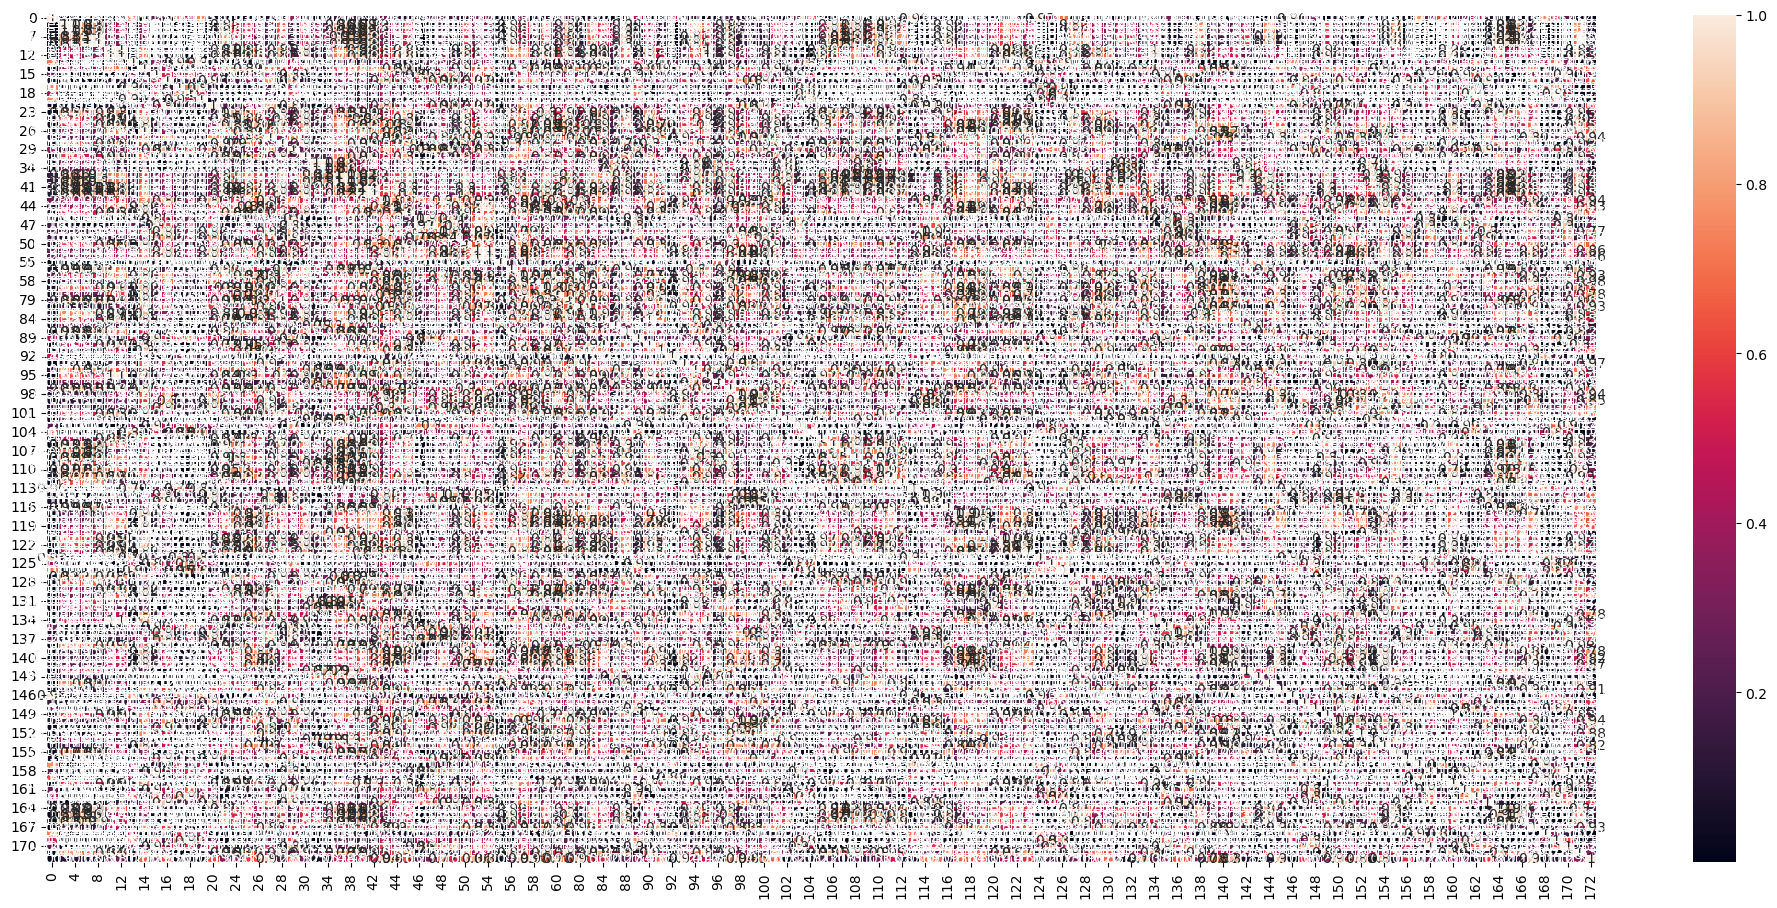

In [110]:
exclude = [("expert_predict", "right")]
#exclude = None

df_accuracy = metricManager.get_metrics_dataframe_cut("verma", "test", "system_accuracy", exclude)
f, ax = plt.subplots(figsize=(50, 11))
ax.set(xlabel='Run', ylabel='Val System Accuracy')
box = sns.boxplot(df_accuracy)
plt.show()
box.figure.savefig("all_runs.png")

df_ttests = pd.DataFrame(check_all_ttest(df_accuracy))
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(25, 11))
sns.heatmap(df_ttests, annot=True, linewidths=.5, ax=ax)

df_runs.loc[[int(el) for el in df_accuracy.columns]]

In [130]:
import dataframe_image as dfi
dfi.export(df_runs, 'df_styled.png', table_conversion="matplotlib", max_rows=-1)

In [106]:
df_accuracy["0"].describe()

count    12.000000
mean     89.303802
std       2.699705
min      82.142857
25%      88.969814
50%      90.116673
75%      90.801034
max      91.954023
Name: 0, dtype: float64

## Group runs

In [945]:
metricManager.get_l2d_dataframe("verma", "val").columns

Index(['n_images', 'system_accuracy', 'expert_accuracy', 'classifier_accuracy',
       'alone_classifier', 'validation_loss', 'n_experts', 'expert_0',
       'expert_1', 'expert_0_coverage', 'expert_1_coverage', 'cov_classifier'],
      dtype='object')

In [19]:
selected_runs["setting"].to_list()

['PERFECT', 'AL', 'SSL', 'SSL_AL', 'NORMAL', 'SSL_AL_SSL']

In [28]:
import matplotlib.ticker as ticker

In [149]:
def row_to_name(row):
    result = row["setting"] + "_"
    row = row.drop("setting")
    for col in row:
        result += col + "_"
    return result[:-1]

l2d Dataframe Columns
Index(['coverage', 'system_accuracy', 'expert_accuracy', 'classifier_accuracy',
       'alone_classifier', 'validation_loss', 'n_experts', 'expert_0',
       'expert_1', 'expert_0_coverage', 'expert_1_coverage', 'cov_classifier'],
      dtype='object')
Index(['Run_0', 'Run_1', 'Run_2', 'Run_3', 'Run_4', 'Run_5', 'Run_6', 'Run_7',
       'Run_8', 'Run_9',
       ...
       'Run_163', 'Run_164', 'Run_165', 'Run_166', 'Run_167', 'Run_168',
       'Run_169', 'Run_170', 'Run_171', 'Run_172'],
      dtype='object', length=173)
Index(['Run_0', 'Run_1', 'Run_2', 'Run_3', 'Run_4', 'Run_5', 'Run_6', 'Run_7',
       'Run_8', 'Run_9',
       ...
       'Run_163', 'Run_164', 'Run_165', 'Run_166', 'Run_167', 'Run_168',
       'Run_169', 'Run_170', 'Run_171', 'Run_172'],
      dtype='object', length=173)


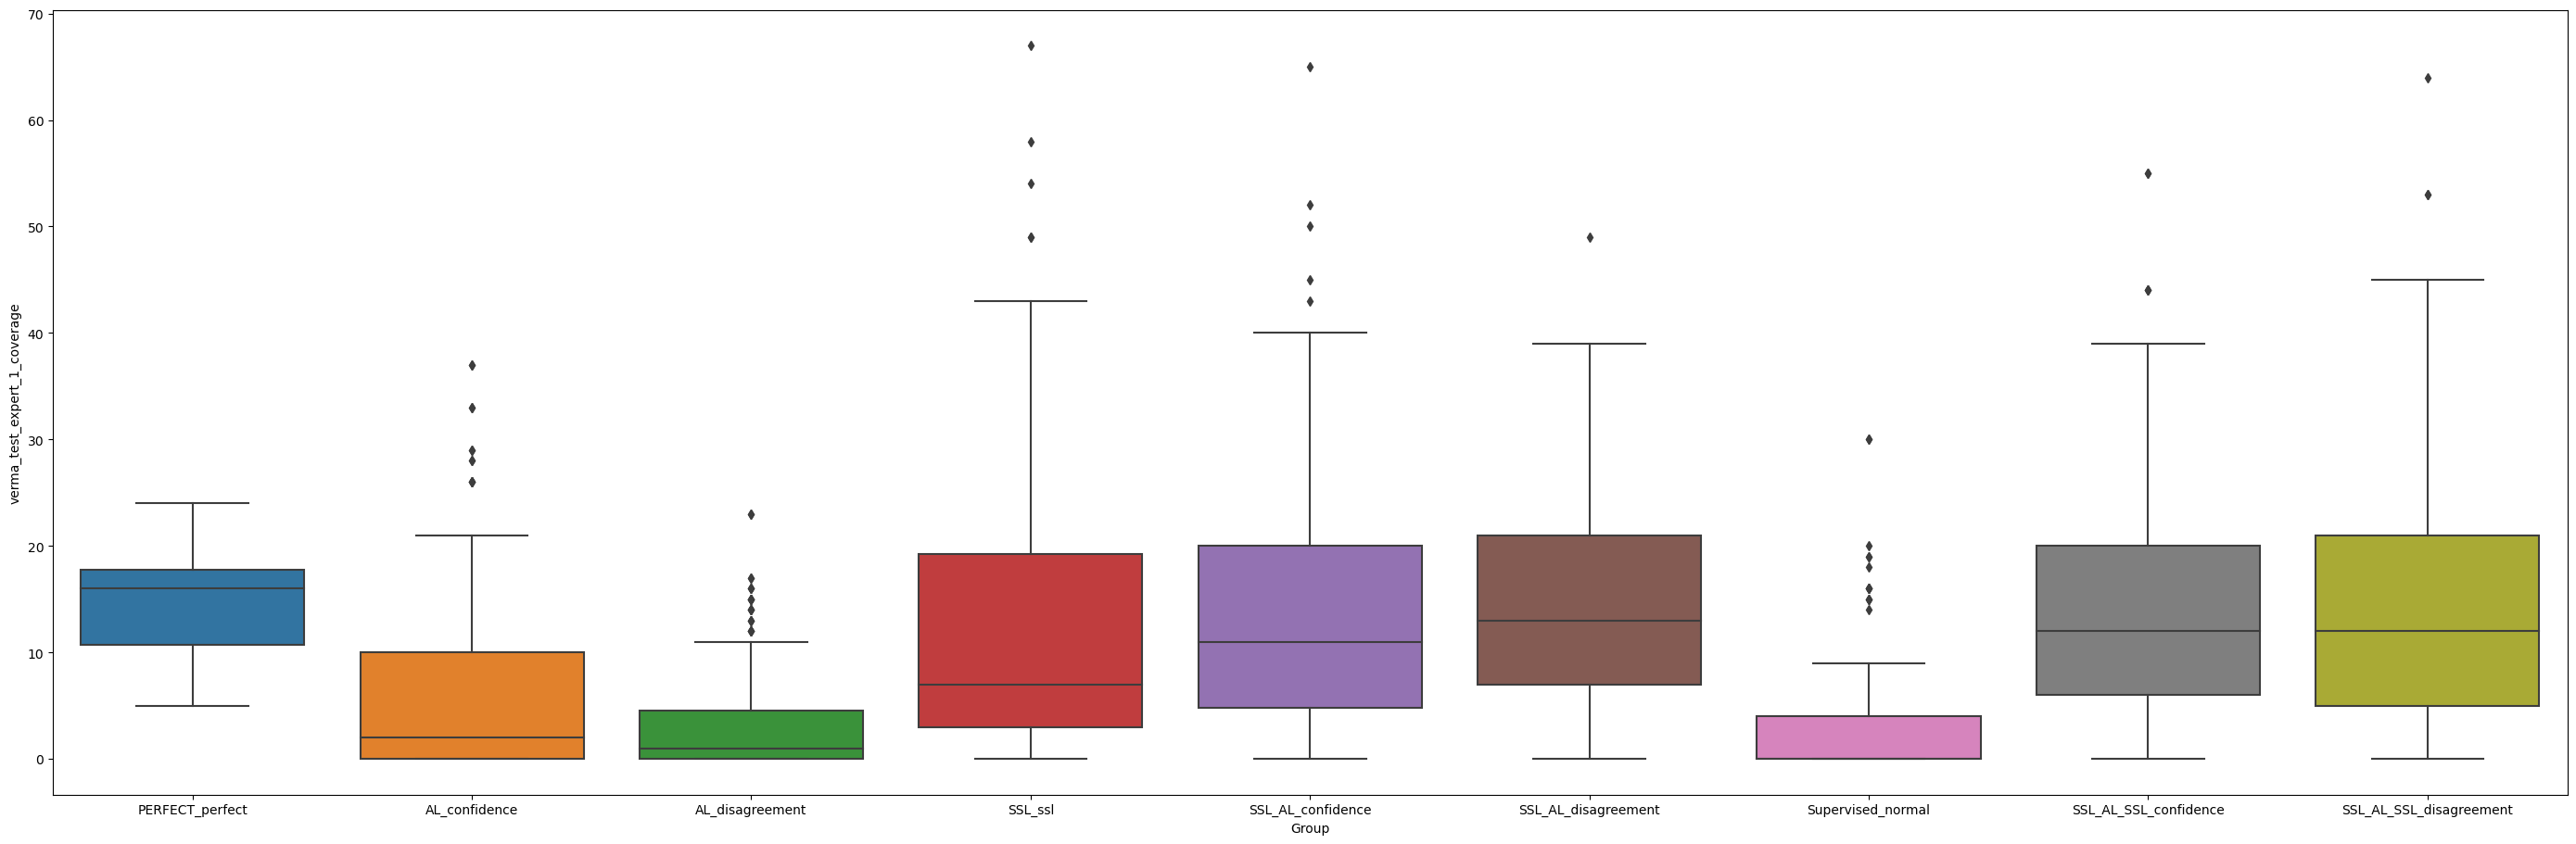

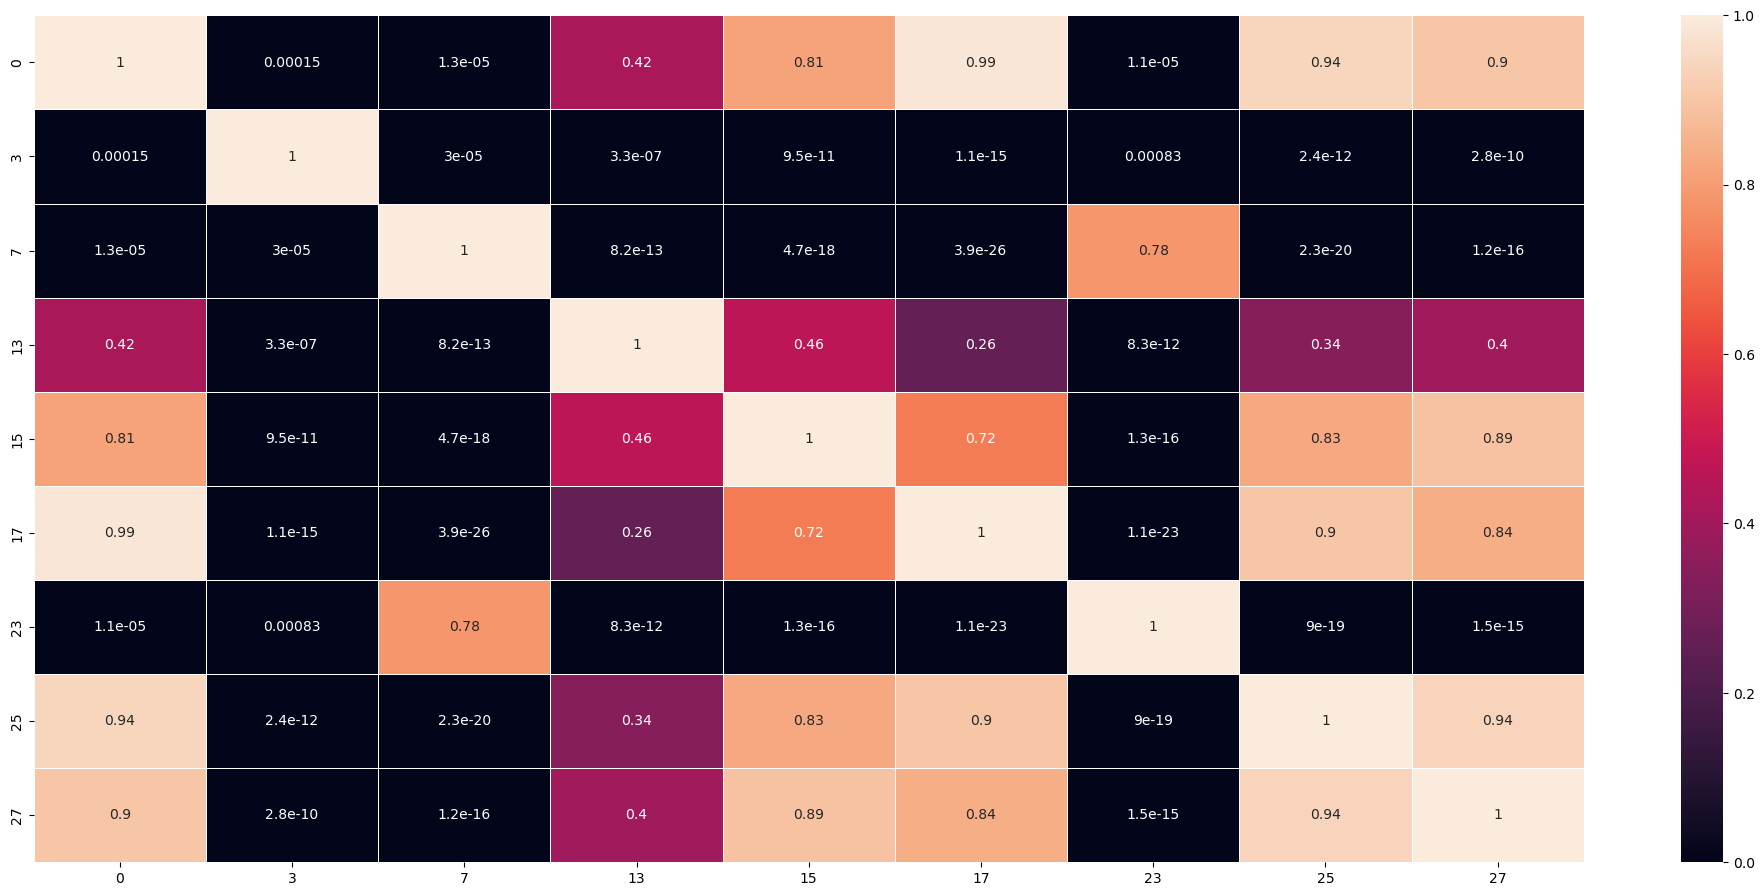

mod     setting
0        perfect     PERFECT
3     confidence          AL
7   disagreement          AL
13           ssl         SSL
15    confidence      SSL_AL
17  disagreement      SSL_AL
23        normal      NORMAL
25    confidence  SSL_AL_SSL
27  disagreement  SSL_AL_SSL

In [249]:
var_columns = ["sample_equal", "overlap", "labeled", "rounds", "init_size", "labels_per_round"]
cut_out = [("expert_predict", "right"), ("mod", "disagreement_diff")]

method = "verma"
metric_name = "expert_1_coverage"
step = "test"

df_test = cut_column_name(metricManager.get_metric_dataframe(method, step, metric_name))
df, selected_runs = get_runs_grouped_metric(df_runs.iloc[:], df_test, var_columns, False, cut_out)
f, ax = plt.subplots(figsize=(35, 11))

box_plot = sns.boxplot(df)

labels = [row_to_name(selected_runs.loc[x]) for x in selected_runs.index]
labels = list(map(lambda x: x.replace('NORMAL', 'Supervised'), labels))
ax.set_xticks(ax.get_xticks(), labels)
ax.set(xlabel='Group', ylabel=f"{method}_{step}_{metric_name}")

box_plot.figure.savefig("all_runs_grouped_cutRightDisagreementdiff.png")
plt.show()
#

m, test_plot = check_all_ttest(df, plot=True)
test_plot.get_figure().savefig("Images/ttest_all_runs_grouped_cutRightDisagreementDisagreementdiff.png")

selected_runs.head(70)

In [186]:
df.describe()

0           3           7           11          13          15  \
count  12.000000  207.000000  207.000000  207.000000  132.000000  132.000000   
mean   91.391115   79.770955   80.117179   80.104602   85.898126   84.527726   
std     1.227162    6.719444    7.447246    7.450544    5.764343    6.300608   
min    89.411765   64.864865   48.809524   48.809524   56.043956   69.047619   
25%    90.524453   75.294118   74.565624   74.712644   82.884777   80.487805   
50%    91.463415   79.310345   80.246914   80.219780   87.209302   85.296563   
75%    91.972272   85.365854   85.714286   85.714286   90.804598   90.552464   
max    93.333333   93.103448   92.708333   93.750000   92.307692   93.023256   

               17          19          23          25          27          29  
count  130.000000  127.000000  127.000000  126.000000  110.000000  102.000000  
mean    85.451729   85.227779   79.306737   85.399449   85.098304   84.845564  
std      6.571515    6.506279    5.348751    5.925577    6.102667    6.449368  
min     66.666667   70.129870   68.235294   67.567568   67.532468   64.935065  
25%     80.304289   79.880952   75.453035   80.984556   81.212023   81.212023  
50%     88.203463   87.500000   79.310345   87.058824   86.535926   86.346692  
75%     91.463415   90.804598   82.085561   90.243902   90.243902   90.210399  
max     92.307692   93.406593   90.804598   96.341463   92.307692   94.252874

### With hue

In [155]:
var_columns = ["sample_equal", "overlap", "cost", "labeled"]

cut_out = [("expert_predict", "right")]

df_test = cut_column_name(metricManager.get_metric_dataframe("verma", "val", "system_accuracy"))
df, runs_df = get_runs_hue_metric(df_runs.iloc[:], df_test, var_columns, cut_out)
group_test = group_ttest(df)

l2d Dataframe Columns
Index(['coverage', 'system_accuracy', 'expert_accuracy', 'classifier_accuracy',
       'alone_classifier', 'validation_loss', 'n_experts', 'expert_0',
       'expert_1', 'expert_0_coverage', 'expert_1_coverage', 'cov_classifier'],
      dtype='object')
Index(['Run_0', 'Run_1', 'Run_2', 'Run_3', 'Run_4', 'Run_5', 'Run_6', 'Run_7',
       'Run_8', 'Run_9',
       ...
       'Run_163', 'Run_164', 'Run_165', 'Run_166', 'Run_167', 'Run_168',
       'Run_169', 'Run_170', 'Run_171', 'Run_172'],
      dtype='object', length=173)


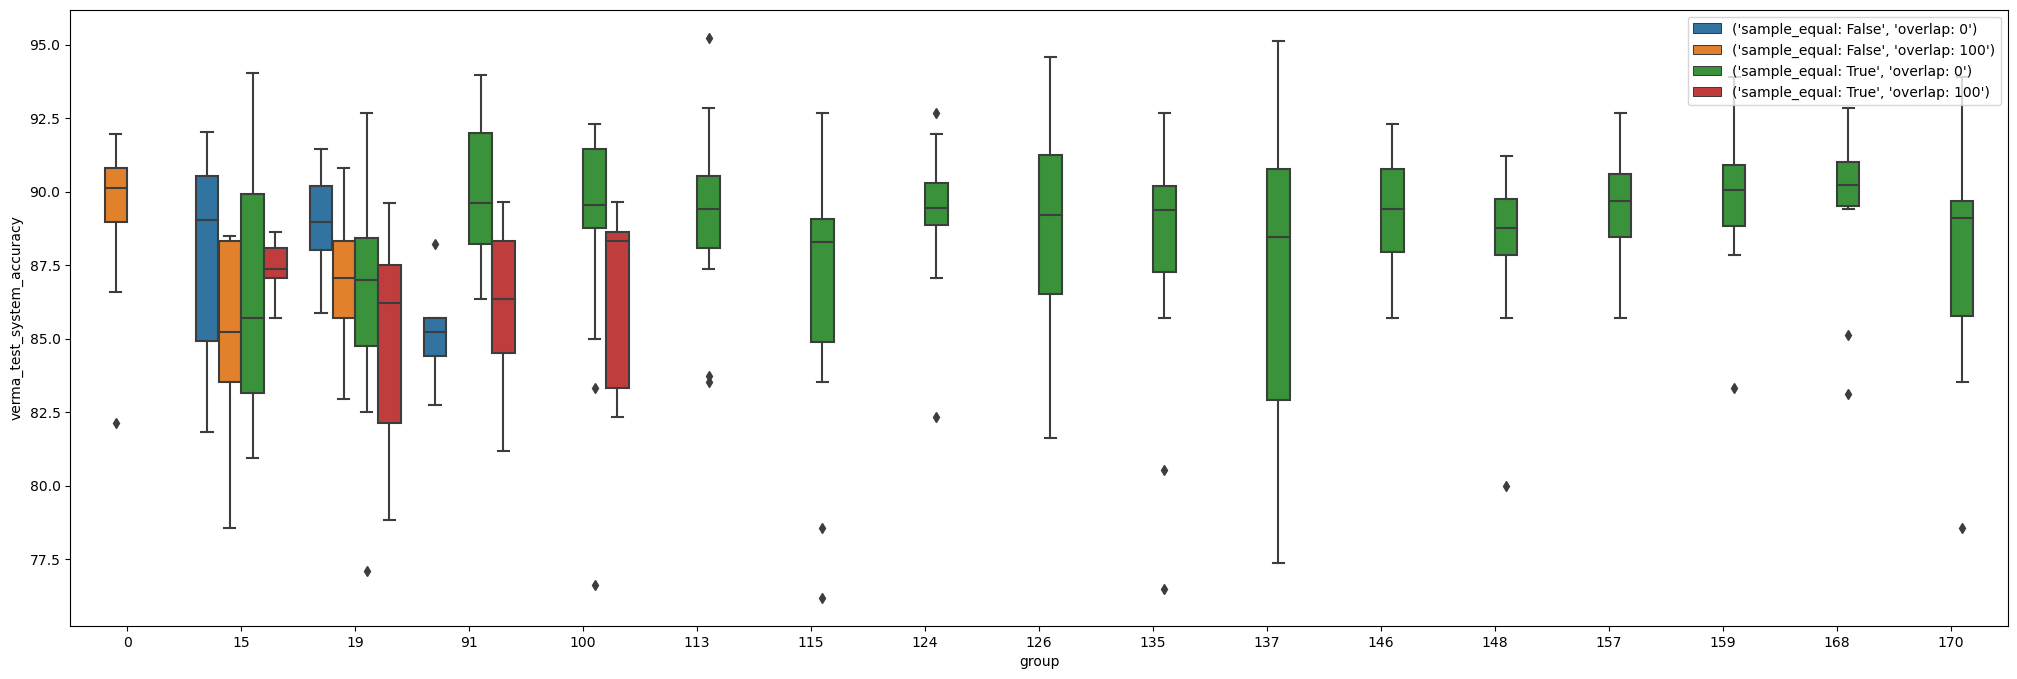

In [256]:
var_columns = ["sample_equal", "overlap"]
cut_out = [("expert_predict", "right"), ("setting", "AL"), ("setting", "NORMAL"), ("mod", "disagreement"), ("setting", "SSL"), ("setting", "SSL_AL_SSL")]

method = "verma"
metric_name = "system_accuracy"
step = "test"

df_test = cut_column_name(metricManager.get_metric_dataframe(method, step, metric_name))
df, runs_df, series = plot_runs_hue_metric(df_runs.iloc[:], df_test, var_columns, cut_out, y_text=f"{method}_{step}_{metric_name}", sorted_columns=["labeled"])
group_test = group_ttest(df)

In [215]:
li = list(series.unique())
li

[(32, 8, 0, 4),
 (12, 2, 4, 4),
 (20, 4, 4, 4),
 (20, 2, 4, 8),
 (36, 4, 4, 8),
 (16, 2, 8, 4),
 (24, 4, 8, 4),
 (24, 2, 8, 8),
 (40, 4, 8, 8)]

In [216]:
def get_index_from_tuple(tuple, name):
    for idx, element in enumerate(tuple):
        if name in element:
            return idx
    return -1

get_index_from_tuple(li[0], "labeled")

TypeError: argument of type 'int' is not iterable

In [214]:
sorted_names = ["labeled", "init_size", "overlap"]
sorted_by_second = sorted(li, key=lambda tup: tuple([tup[idx] for idx in [get_index_from_tuple(tup, name) for name in sorted_names]]))
ser = pd.Series(sorted_by_second)
ser.head()

def get_index_from_tuple(tuple, name):
    for idx, element in enumerate(tuple):
        if name in element:
            return idx
    return -1

NameError: name 'li' is not defined

### Hue with grouped 

In [239]:
def plot_runs_hue_metric(df_runs, df_metrics, var_columns, unwanted_tuples=None, y_text="value", sorted_columns=None, size=(25, 8)):
    df, runs_df = get_runs_hue_metric(df_runs.iloc[:], df_metrics, var_columns, unwanted_tuples)

    f, ax = plt.subplots(figsize=size)

    #df_perfect = df[df["group"] == 0]
    #df = df[df["group"] != 0]

    #f = plt.figure()

    #ax = f.add_subplot(2, 2, 1)

    display(HTML(runs_df.to_html()))

    #lis = sorted(df[var_columns].apply(tuple, axis=1), key=lambda tup: tup[0])
    lis = df[var_columns].apply(tuple, axis=1)
    sort = sorted(list(lis.unique()), key=lambda tup: tuple([tup[idx] for idx in [get_index_from_tuple(var_columns, name) for name in var_columns]]))

    g = sns.boxplot(df, y="value", x="group", hue=lis, hue_order=sort)

    ax.set(xlabel='group', ylabel=y_text)

    series = pd.Series(df[var_columns].apply(tuple, axis=1))
    for i in range(len(var_columns)):
        name = var_columns[i]
        for j, el in enumerate(series):
            el = list(series.iloc[j])
            el[i] = f"{name}: {el[i]}"
            series.iloc[j] = tuple(el)

    li = list(series.unique())
    sorted_list = sorted(li, key=lambda tup: tuple([tup[idx] for idx in [get_index_from_tuple(tup, name) for name in var_columns]]))

    plt.legend(loc='upper right')
    for t, l in zip(g.legend_.texts, sorted_list):
        t.set_text(l)

    plt.show(g)

    return df, runs_df, lis

In [44]:
lis = list(series.unique())
lis = sorted(lis, key=lambda tup: tup[0])
lis

[(12, 2, 4, 4),
 (16, 2, 8, 4),
 (20, 4, 4, 4),
 (20, 2, 4, 8),
 (24, 4, 8, 4),
 (24, 2, 8, 8),
 (32, 8, 0, 4),
 (36, 4, 4, 8),
 (40, 4, 8, 8)]

In [ ]:
grouped_columns = ["sample_equal", "overlap"]
cut_out = [("expert_predict", "right"), ("mod", "disagreement")]
var_columns = ["labeled", "rounds", "init_size", "labels_per_round"]

method = "verma"
metric_name = "system_accuracy"
step = "test"

df_test = cut_column_name(metricManager.get_metric_dataframe(method, step, metric_name))
df_grouped_metrics, selected_runs = get_runs_grouped_metric(df_runs.iloc[:], df_test, grouped_columns, False, cut_out)

df_grouped_metrics.columns = [str(name) for name in df_grouped_metrics.columns]

df, runs_df, series = plot_runs_hue_metric(selected_runs, df_grouped_metrics, var_columns, cut_out, y_text=f"{method}_{step}_{metric_name}")
group_test = group_ttest(df)

l2d Dataframe Columns
Index(['coverage', 'system_accuracy', 'expert_accuracy', 'classifier_accuracy',
       'alone_classifier', 'validation_loss', 'n_experts', 'expert_0',
       'expert_1', 'expert_0_coverage', 'expert_1_coverage', 'cov_classifier'],
      dtype='object')
Index(['Run_0', 'Run_1', 'Run_2', 'Run_3', 'Run_4', 'Run_5', 'Run_6', 'Run_7',
       'Run_8', 'Run_9',
       ...
       'Run_163', 'Run_164', 'Run_165', 'Run_166', 'Run_167', 'Run_168',
       'Run_169', 'Run_170', 'Run_171', 'Run_172'],
      dtype='object', length=173)
[[0], [15, 16, 45, 46], [91, 92, 98], [113], [124], [135], [146], [157], [168]]
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '163', '164', '165', '166', '167', '168', '169', '170', '171', '172'],
      dtype='object', length=173)


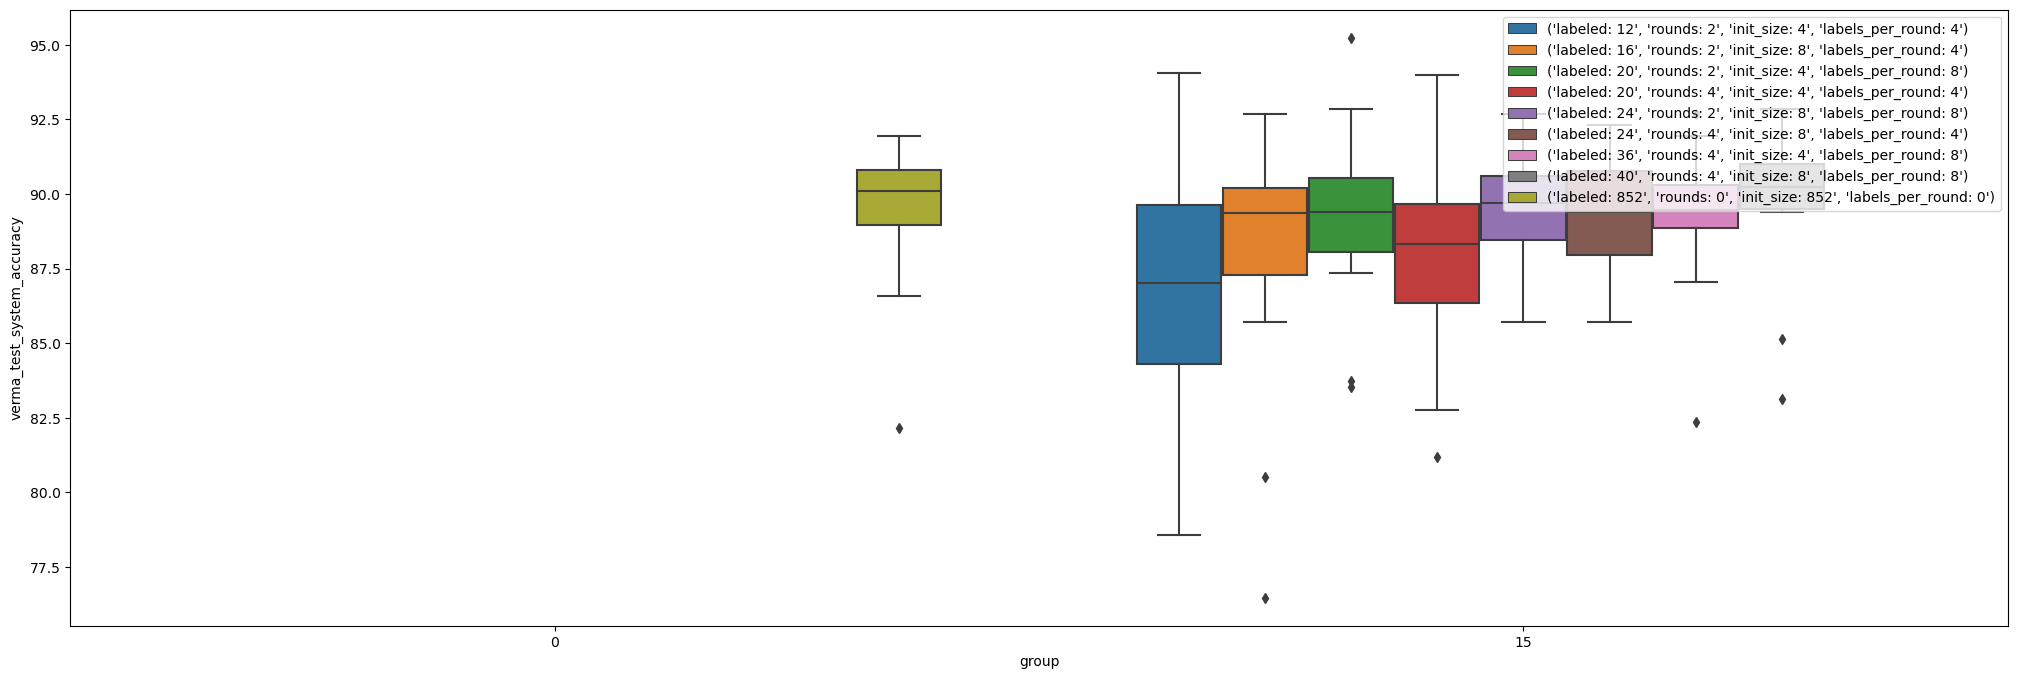

In [237]:
grouped_columns = ["sample_equal", "overlap"]
cut_out = [("expert_predict", "right"), ("mod", "disagreement_diff"), ("mod", "disagreement"), ("setting", "AL"), ("setting", "SSL"), ("setting", "NORMAL"), ("setting", "SSL_AL_SSL")]
var_columns = ["labeled", "rounds", "init_size", "labels_per_round"]

method = "verma"
metric_name = "system_accuracy"
step = "test"

df_test = cut_column_name(metricManager.get_metric_dataframe(method, step, metric_name))
df_grouped_metrics, selected_runs = get_runs_grouped_metric(df_runs.iloc[:], df_test, grouped_columns, False, cut_out)

df_grouped_metrics.columns = [str(name) for name in df_grouped_metrics.columns]

df, runs_df, series = plot_runs_hue_metric(selected_runs, df_grouped_metrics, var_columns, cut_out, y_text=f"{method}_{step}_{metric_name}")
group_test = group_ttest(df)

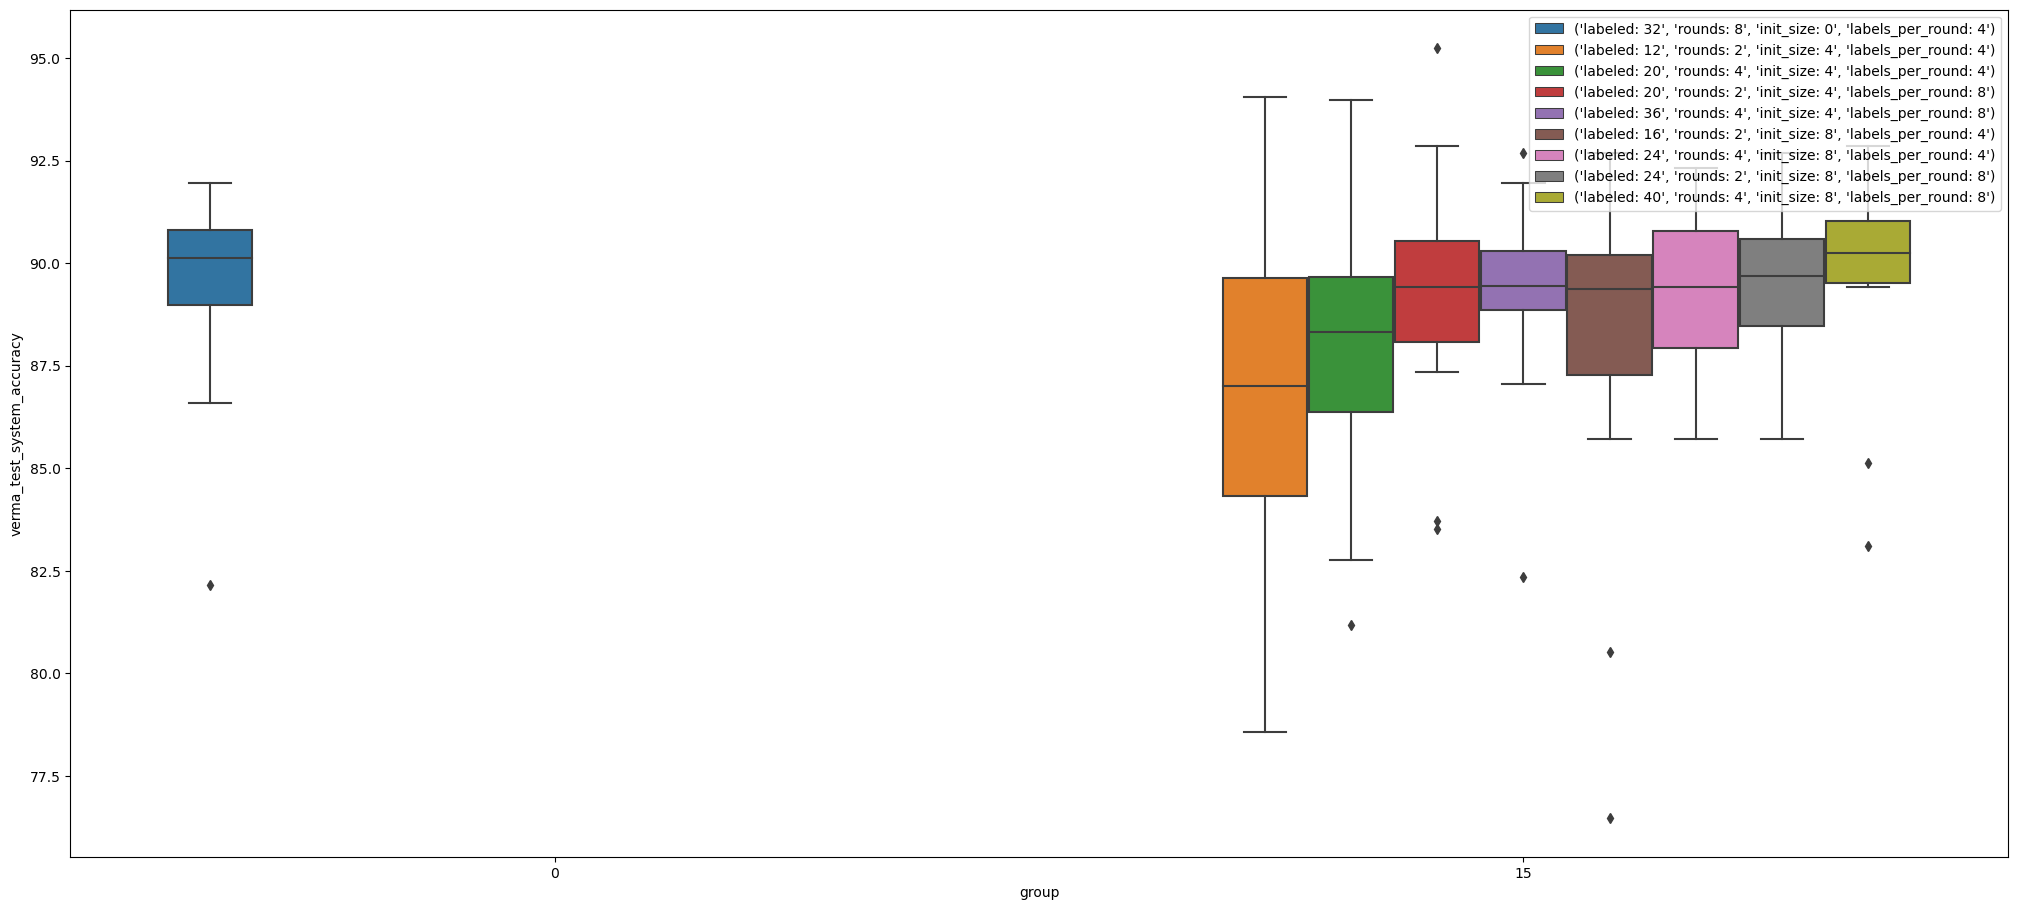

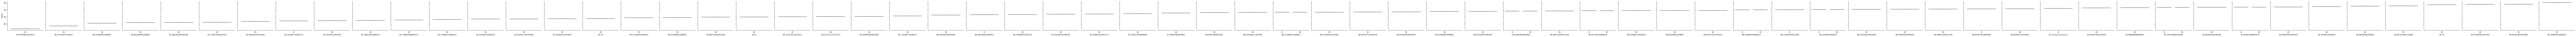

In [48]:
grouped_columns = ["sample_equal", "overlap"]
cut_out = [("expert_predict", "right"), ("mod", "disagreement_diff"), ("mod", "disagreement"), ("setting", "AL"), ("setting", "SSL"), ("setting", "NORMAL"), ("setting", "SSL_AL_SSL")]
var_columns = ["labeled", "rounds", "init_size", "labels_per_round"]

method = "verma"
metric_name = "system_accuracy"
step = "test"

df_test = cut_column_name(metricManager.get_metric_dataframe(method, step, metric_name))
df_grouped_metrics, selected_runs = get_runs_grouped_metric(df_runs.iloc[:], df_test, grouped_columns, False, cut_out)

df_grouped_metrics.columns = [str(name) for name in df_grouped_metrics.columns]

df, runs_df, series = plot_runs_hue_metric(selected_runs, df_grouped_metrics, var_columns, cut_out, y_text=f"{method}_{step}_{metric_name}")
#group_test = group_ttest(df)

plt.show()

### Test area

In [ ]:
def get_rungroup_name(df_runs, runs_g, var_columns, reverse=False):
    """
    Create names for every run where the runs differentiate in parameters

    Input:
        df_runs: DataFrame with every run and its parameters
        runs_g: Group of runs in structure [[0, 1, 2], [3, 4]]
        var_columns: Names of columns which can vary in a aggregated run
        reverse: If all columns could vary except of the given ones

    Return:
        run_names: Names for every run
        keys: Columnnames in which the runs are different
    """
    const_columns = [column for column in df_runs.columns if column not in var_columns]
    if reverse:
        const_columns = var_columns

    group_dict = []
    for run_group in runs_g:
        group_dict.append(dict(df_runs.loc[run_group[0], const_columns]))

    keys = []
    for i in range(len(group_dict) - 1):
        temp_keys = [k for k in group_dict[i] if group_dict[i][k] != group_dict[i + 1][k]]
        for key in temp_keys:
            if key not in keys:
                keys.append(key)
    keys.reverse()

    run_names = []
    for run_group in runs_g:
        run_names.append(create_run_name_from_columns(df_runs.loc[run_group[0]], keys))

    return run_names, keys

def create_run_name_from_columns(run, columns):
    """
    Concats names of columns with value for one run

    Input:
        run: DataFrame which contains one run with its parameters
        columns: The columns to build the name

    Return:
        Concated string from column-value pairs
    """
    name = ""
    #columns.reverse()
    for column in columns:
        name = name + f"{column}_{run.loc[column]}_"
    return name[:-1]


def get_runs_grouped(df, var_columns, reverse=False):
    """
    Groups the runs by their parameters
    All parameters except the passed ones are equal

    Returns a list whichs elements are lists of equal runs like [[0, 1, 2], [3, 4, 5]]
    """
    #Gets the columns which defines a aggregated run (stay constant for on aggregation)
    const_columns = [column for column in df.columns if column not in var_columns]
    #If all columns should be variable except the given ones
    if reverse:
        const_columns = var_columns

    pairs = []
    referenc_row = None
    index_list = list(df.index)
    #For every run in the dataframe
    for index in df.index:
        #If the run already is aggregated into one group
        if index in [el for sublist in pairs for el in sublist]:
            continue
        #Remove index to prevent adding it into the group to himself
        index_list.remove(index)
        #Get the reference row with the conctant columns
        referenc_row = df.loc[index, const_columns].to_dict()
        pair = [index]
        #Look at all other runs
        for index_j in index_list:
            current_row = df.loc[index_j, const_columns].to_dict()
            #If the current row equals the reference  row in the constant columns
            if referenc_row == current_row:
                pair.append(index_j)
        #Removed aggregated rows to prevent aggregation into different groups
        for el in pair:
            if el in index_list:
                index_list.remove(el)
        pairs.append(pair)
    return pairs

def get_runs_grouped_metric(df_runs, df_metrics, var_columns, reverse=False, unwanted_tuples=None):
    """
    Returns a DataFrame where the runs are aggregated and metrics for are combined for a aggregation

    A Aggregated run contains all metrics for every run it contains
    
    Parameter:
        var_columns are the coulmns which aren't fix, all other are
        Reverse makes all columns variable except var_columns

    Return:
        df - The DataFrame which contains aggregated runs with metrics
        df_runs.loc[first_indices, keys] - List of the aggregated runs from df_runs to show the parameters of the aggregated runs
    """

    #Remove unwanted runs
    if unwanted_tuples is not None:
        df_runs = remove_unwanted_runs(df_runs, unwanted_tuples)
    df_runs = runs_cost_to_string(df_runs)
    #Get groups of runs
    g_runs = get_runs_grouped(df_runs, var_columns, reverse)
    df = None
    first_indices = []
    for run_group in g_runs:
        #Append first run of group to show the parameters of a group
        first_indices.append(run_group[0])
        values = []
        #For every run in a group
        for run in run_group:
            #Aggregate the values of every run in this group
            values = values + df_metrics[str(run)].tolist()
        #Create Dataframe with aggregated values
        dff = pd.DataFrame(values, columns=[str(run_group)])
        #If first element of the group create Dataframe
        if df is None:
            df = dff
        else: #Concat for every other run in the group
            df = pd.concat([df, dff], axis=1)

    #keys are the columns of runs where the values are different in the aggregated runs
    #Prevents from printing column-values which are constant over all run groups
    df.columns, keys = get_rungroup_name(df_runs, g_runs, var_columns, reverse)

    df.columns = df_runs.loc[first_indices, keys].index
    
    return df, df_runs.loc[first_indices, keys]

def get_runs_hue_metric(df_runs, df_metrics, var_columns, unwanted_tuples=None):
    """
    Creates a DataFrame in long formate (for seaborn) which groups runs over equal columns and changing var_columns

    Parameter:
        df_runs: DataFrame containing all runs
        df_metrics: DataFrame containing values for one metric over every run and every fold (Columns are runs, rows are the max/var of the L2D systems metric for every fold)
        var_columns: Columns which can vary in a aggregated run
        unwanted_tuples: parameter-value pairs of runs which should be removed
    """
    if unwanted_tuples is not None:
        df_runs = remove_unwanted_runs(df_runs, unwanted_tuples)
    df_runs = runs_cost_to_string(df_runs)
    
    g_runs = get_runs_grouped(df_runs, var_columns, False)

    df = None
    first_indices = []
    dfs = []
    for run_group in g_runs:
        first_indices.append(run_group[0])
        values = {}
        run_dfs = []
        for run in run_group:
            temp_dict = {
                "value": df_metrics[str(run)],
            }
            for column in var_columns:
                temp_dict[column] = [df_runs.loc[run, column] for i in range(len(temp_dict["value"]))]
            df = pd.DataFrame(temp_dict)
            #print(df)
            run_dfs.append(df)
        dff = pd.concat(run_dfs)
        dff["group"] = [run_group[0] for i in range(len(dff))]
        dfs.append(dff)

    _, keys = get_rungroup_name(df_runs, g_runs, var_columns, False)
    
    return pd.concat(dfs), df_runs.loc[first_indices, keys]

def plot_runs_hue_metric(df_runs, df_metrics, var_columns, unwanted_tuples=None, y_text="value", sorted_columns=None):
    df, runs_df = get_runs_hue_metric(df_runs.iloc[:], df_metrics, var_columns, unwanted_tuples)

    f, ax = plt.subplots(figsize=(25, 11))

    display(HTML(runs_df.to_html()))

    #lis = sorted(df[var_columns].apply(tuple, axis=1), key=lambda tup: tup[0])
    lis = df[var_columns].apply(tuple, axis=1)

    g = sns.boxplot(df, y="value", x="group", hue=lis)

    ax.set(xlabel='group', ylabel=y_text)

    series = pd.Series(df[var_columns].apply(tuple, axis=1))
    for i in range(len(var_columns)):
        name = var_columns[i]
        for j, el in enumerate(series):
            el = list(series.iloc[j])
            el[i] = f"{name}: {el[i]}"
            series.iloc[j] = tuple(el)

    if sorted_columns is not None:
        li = list(series.unique())
        sorted_list = sorted(li, key=lambda tup: tuple([tup[idx] for idx in [get_index_from_tuple(tup, name) for name in sorted_columns]]))
    else:
        sorted_list = list(series.unique())

    plt.legend(loc='upper right')
    for t, l in zip(g.legend_.texts, sorted_list):
        t.set_text(l)

    plt.show(g)

    return df, runs_df, lis


def get_index_from_tuple(tuple, name):
    for idx, element in enumerate(tuple):
        if name in element:
            return idx
    return -1


def get_uniq_values(df, column):
    if column in df.columns:
        return set(df[column].values)

def group_ttest(df, plot=False):

    group_test = []
    df = runs_cost_to_string(df)
    for group in get_uniq_values(df, "group"):
        group_df = df[df["group"] == group]

        columns = list(group_df.columns)
        columns.remove("value")
        columns.remove("group")

        dff = group_df.pivot(columns=columns, values='value')

        group_test.append(pd.DataFrame(check_all_ttest(dff)))

    return group_test



## Experts

In [482]:
class ExpertMetrics:
    def __init__(self, metrics):
        self.metric = metrics

        self.runs = pd.DataFrame(metrics).drop(["expert metrics", "verma", "hemmer"], axis=1)

        self.expert_values = {
            "Val": {},
            "Test": {},
        }

    def get_experts_in_run(self, run):
        seed = list(self.metric[run]["expert metrics"].keys())[0]
        fold = list(self.metric[run]["expert metrics"][seed].keys())[0]
        return list(self.metric[run]["expert metrics"][seed][fold].keys())

    def creat_expert_run(self, expertId, run, step, metric_name):
        run_dict = {}
        for seed, value1 in self.metric[run]["expert metrics"].items():
            seed_dict = {}
            for fold, value2 in value1.items():
                expert_metric = value2[expertId][step]
                fold_dict = {}
                fold_dict["End"] = expert_metric["End"][metric_name]
                if "Start" in expert_metric:
                    fold_dict["Start"] = expert_metric["Start"][metric_name]
                else:
                    fold_dict["Start"] = expert_metric["End"][metric_name]
                seed_dict[f"Fold_{fold}"] = pd.DataFrame(fold_dict, index=[0])
            run_dict[f"Seed_{seed}"] =  pd.concat(seed_dict, ignore_index=True)
        return pd.concat(run_dict)

    def create_expert_metric(self, expertId, step, metric_name):
        run_metrics = {}
        for run_id in range(len(self.metric)):
            run_metrics[f"Run_{run_id}"] = self.creat_expert_run(expertId, run_id, step, metric_name)
        return pd.concat(run_metrics)

    def create_plot_df(self, expertId, step, metric_name, unwanted_tuples=None):
        if unwanted_tuples is not None:
            runs = remove_unwanted_runs(self.runs, unwanted_tuples).index
        else:
            runs = self.runs.index

        df = expertMetrics.create_expert_metric(4323195249, step, metric_name).reset_index()
        dff = df.melt(id_vars=["level_0", "level_1", "level_2"])
        dff["level_2"] = dff["level_2"].apply(lambda x: str(x))
        dff["run"] = dff["level_0"].apply(lambda x: int(x[4:]))
        dff.head()
        dff["seed_fold"] = dff["level_1"] + "_Fold_"+ dff["level_2"]
        dff = dff.drop(["level_1", "level_2", "seed_fold", "level_0"], axis=1)
        return dff[dff["run"].isin(runs)]

    def create_plot_df_grouped(self, expertId, step, metric_name, var_columns, unwanted_tuples=None):
        if unwanted_tuples is not None:
            df_runs = remove_unwanted_runs(self.runs, unwanted_tuples)
        else:
            df_runs = self.runs
        df_runs = runs_cost_to_string(df_runs)
    
        g_runs = get_runs_grouped(df_runs, var_columns, False)

        df = expertMetrics.create_expert_metric(4323195249, step, metric_name).reset_index()
        dff = df.melt(id_vars=["level_0", "level_1", "level_2"])
        dff["level_2"] = dff["level_2"].apply(lambda x: str(x))
        dff["run"] = dff["level_0"].apply(lambda x: int(x[4:]))
        dff["seed_fold"] = dff["level_1"] + "_Fold_"+ dff["level_2"]
        dff = dff.drop(["level_1", "level_2", "seed_fold", "level_0"], axis=1)
        dff["group"] = -1

        dff = dff[dff["run"].isin(df_runs.index)]
            
        dff["group"] = dff.apply(lambda row: g_runs[getGroupIndex(g_runs, row["run"])][0], axis=1)

        #keys are the columns of runs where the values are different in the aggregated runs
        #Prevents from printing column-values which are constant over all run groups
        temp1, keys = get_rungroup_name(df_runs, g_runs, var_columns, False)

        print(temp1)
        print(keys)

        #df.columns = df_runs.loc[first_indices, keys].index
    
        #return df, df_runs.loc[first_indices, keys]
        
        return dff, df_runs


    
    def create_expert_values(self, step, metric_name):
        """
        Creates a list which contains the start and end metric for the given step (val, test) for every run and expert
        List index is run, which contains dictionaries of expertid:Seed_Fold_Metric
        """
        mett = []
        for run in self.metric:
            met = {}
            for seed, value1 in run["expert metrics"].items():
                for fold, value2 in value1.items():
                    for expert, value3 in value2.items():
                        if expert not in met:
                            met[expert] = {}
                        met[expert][f"Seed_{seed}_Fold_{fold}"] = {}
                        met[expert][f"Seed_{seed}_Fold_{fold}"]["End"] = value3[step]["End"][metric_name]
                        if "Start" in value3[step]:
                            met[expert][f"Seed_{seed}_Fold_{fold}"]["Start"] = value3[step]["Start"][metric_name]
                        else:
                            pass
            mett.append(met)
        return mett

    def get_expert_values(self, step, metric_name):
        if metric_name not in self.expert_values[step]:
            self.expert_values[step][metric_name] = self.create_expert_values(step, metric_name)
        return self.expert_values[step][metric_name]

    def get_single_run(self, run, step, metric_name):
        return self.get_expert_values(step, metric_name)[run]

    def print_metrics(self):
        print("tn, fp, fn, tp, accurancy, f1, accurancy_balanced")


def getGroupIndex(groups, x):
    for i in range(len(groups)):
        if x in groups[i]:
            return i

expertMetrics = ExpertMetrics(metrics2)

In [392]:
expertMetrics.get_experts_in_run(0)

[4323195249, 4295232296]

In [464]:
unwanted_tuples = [("expert predict", "right"), ("mod", "disagreement")]
df_plot = expertMetrics.create_plot_df(4323195249, "Test", "accurancy_balanced", unwanted_tuples=unwanted_tuples)
df_plot

ValueError: too many values to unpack (expected 2)

In [419]:
next(df_plot.iterrows())

(0,
 variable    End
 value       1.0
 run           0
 group        -1
 Name: 0, dtype: object)

In [483]:
var_columns = ["sample_equal", "overlap", "labeled", "rounds", "init_size", "labels_per_round"]
cut_out = [("expert_predict", "right"), ("mod", "disagreement_diff")]


df_plot, df_runs = expertMetrics.create_plot_df_grouped(4323195249, "Test", "accurancy_balanced", var_columns=var_columns, unwanted_tuples=cut_out)
df_plot

['mod_perfect_setting_PERFECT', 'mod_confidence_setting_AL', 'mod_disagreement_setting_AL', 'mod_ssl_setting_SSL', 'mod_confidence_setting_SSL_AL', 'mod_disagreement_setting_SSL_AL', 'mod_normal_setting_NORMAL', 'mod_confidence_setting_SSL_AL_SSL', 'mod_disagreement_setting_SSL_AL_SSL']
['mod', 'setting']


variable     value  run  group
0         End  1.000000    0      0
1         End  1.000000    0      0
2         End  1.000000    0      0
3         End  1.000000    0      0
4         End  1.000000    0      0
...       ...       ...  ...    ...
4173    Start  0.613173  172     25
4174    Start  0.735294  172     25
4175    Start  0.533333  172     25
4176    Start  0.534091  172     25
4177    Start  0.543478  172     25

[2366 rows x 4 columns]

In [484]:
len(set(list(df_plot["group"])))

9

labeler_ids  init_size  labels_per_round  rounds  labeled  \
0   [4323195249, 4295232296]        852                 0       0      852   
3   [4323195249, 4295232296]          4                 4       2       12   
4   [4323195249, 4295232296]          4                 4       2       12   
7   [4323195249, 4295232296]          4                 4       2       12   
8   [4323195249, 4295232296]          4                 4       2       12   
13  [4323195249, 4295232296]          4                 4       2       12   
14  [4323195249, 4295232296]          4                 4       2       12   
15  [4323195249, 4295232296]          4                 4       2       12   
16  [4323195249, 4295232296]          4                 4       2       12   
17  [4323195249, 4295232296]          4                 4       2       12   
18  [4323195249, 4295232296]          4                 4       2       12   
23  [4323195249, 4295232296]          4                 4       2       12   
24  [4323195249, 4295232296]          4                 4       2       12   
25  [4323195249, 4295232296]          4                 4       2       12   
26  [4323195249, 4295232296]          4                 4       2       12   
27  [4323195249, 4295232296]          4                 4       2       12   
28  [4323195249, 4295232296]          4                 4       2       12   
33  [4323195249, 4295232296]          4                 4       2       12   
34  [4323195249, 4295232296]          4                 4       2       12   
37  [4323195249, 4295232296]          4                 4       2       12   
38  [4323195249, 4295232296]          4                 4       2       12   
43  [4323195249, 4295232296]          4                 4       2       12   
44  [4323195249, 4295232296]          4                 4       2       12   
45  [4323195249, 4295232296]          4                 4       2       12   
46  [4323195249, 4295232296]          4                 4       2       12   
47  [4323195249, 4295232296]          4                 4       2       12   
48  [4323195249, 4295232296]          4                 4       2       12   
53  [4323195249, 4295232296]          4                 4       2       12   
54  [4323195249, 4295232296]          4                 4       2       12   
55  [4323195249, 4295232296]          4                 4       2       12   

      cost  overlap     setting           mod expert_predict  sample_equal  \
0   (0, 0)      100     PERFECT       perfect         target         False   
3   (0, 0)        0          AL    confidence         target         False   
4   (0, 0)        0          AL    confidence         target          True   
7   (0, 0)        0          AL  disagreement         target         False   
8   (0, 0)        0          AL  disagreement         target          True   
13  (0, 0)        0         SSL           ssl         target         False   
14  (0, 0)        0         SSL           ssl         target          True   
15  (0, 0)        0      SSL_AL    confidence         target         False   
16  (0, 0)        0      SSL_AL    confidence         target          True   
17  (0, 0)        0      SSL_AL  disagreement         target         False   
18  (0, 0)        0      SSL_AL  disagreement         target          True   
23  (0, 0)        0      NORMAL        normal         target         False   
24  (0, 0)        0      NORMAL        normal         target          True   
25  (0, 0)        0  SSL_AL_SSL    confidence         target         False   
26  (0, 0)        0  SSL_AL_SSL    confidence         target          True   
27  (0, 0)        0  SSL_AL_SSL  disagreement         target         False   
28  (0, 0)        0  SSL_AL_SSL  disagreement         target          True   
33  (0, 0)      100          AL    confidence         target         False   
34  (0, 0)      100          AL    confidence         target          True   
37  (0, 0)      100          AL  disag

<Figure size 640x480 with 0 Axes>

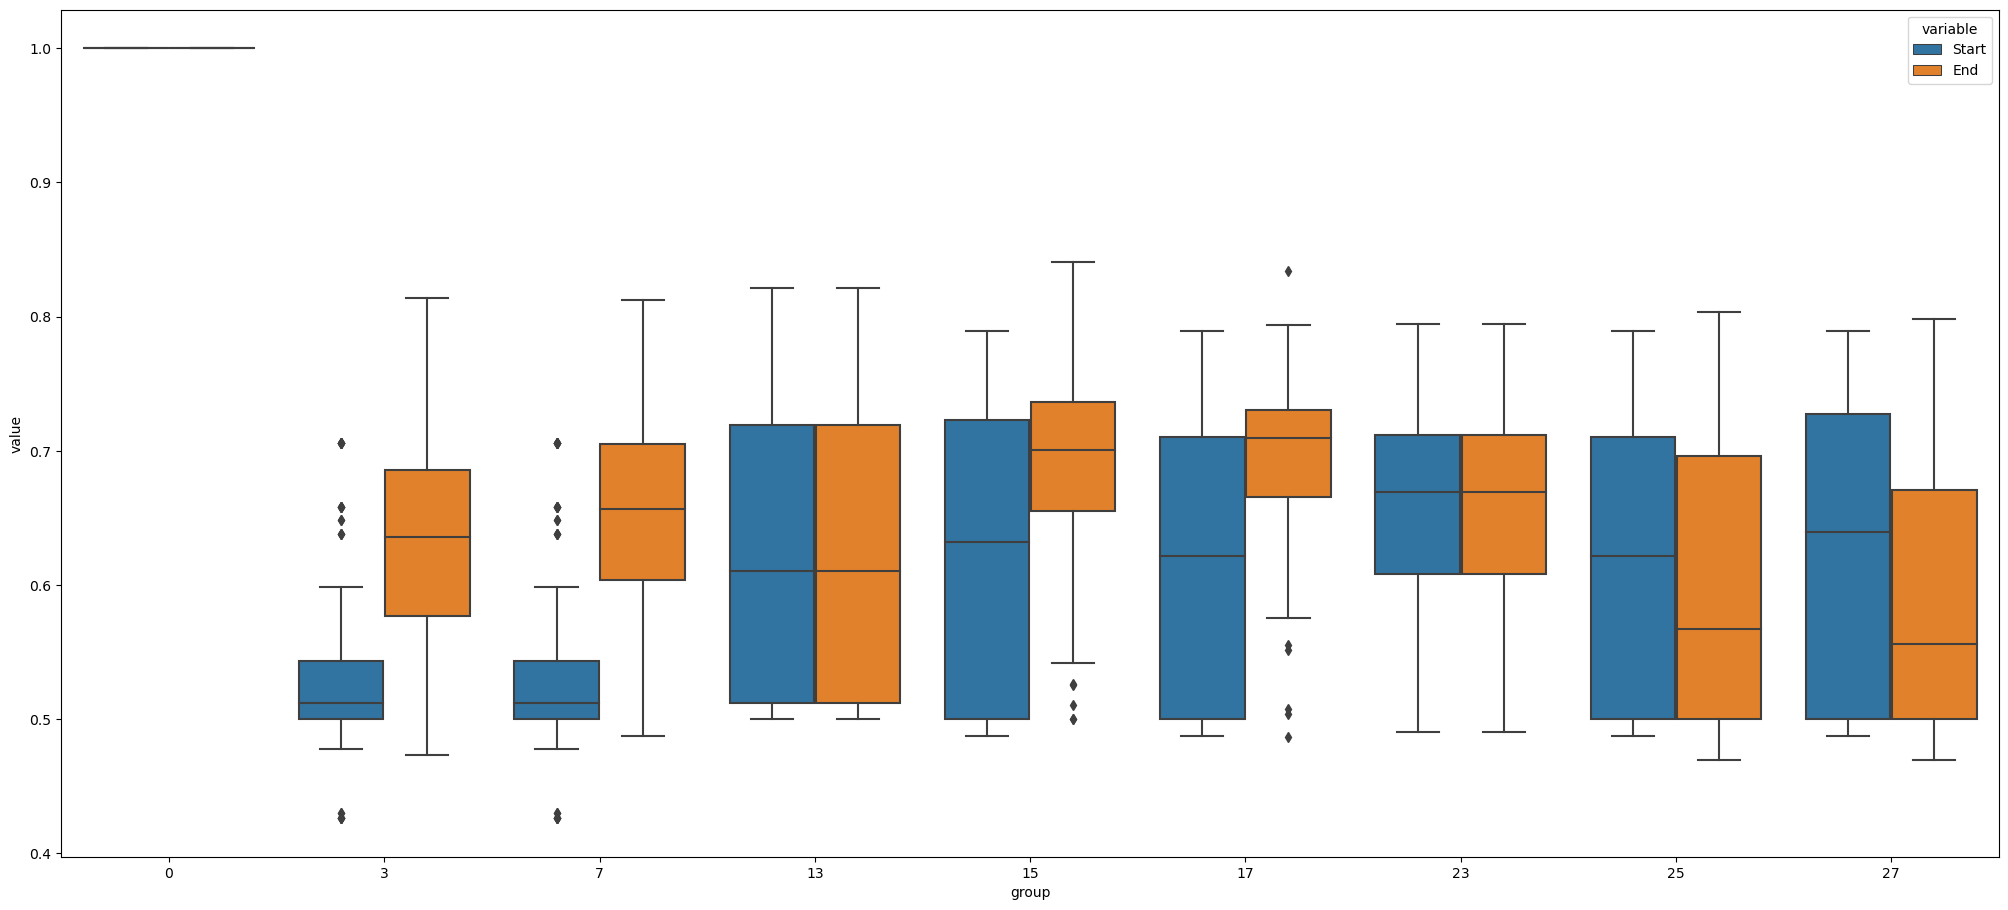

In [485]:
plt.figure()
f, ax = plt.subplots(figsize=(25, 11))
sns.boxplot(df_plot, x="group", y="value", hue="variable", hue_order=["Start", "End"], ax=ax)

df_runs.head(30)

In [268]:
pd.DataFrame(expertMetrics.get_single_run(1, "Test", "f1"))

4323195249  \
Seed_1_Fold_0          {'End': 0.46, 'Start': 0.5370370370370371}   
Seed_1_Fold_1       {'End': 0.71875, 'Start': 0.5840707964601769}   
Seed_1_Fold_2   {'End': 0.8689655172413793, 'Start': 0.9554140...   
Seed_1_Fold_3   {'End': 0.7832167832167831, 'Start': 0.5691056...   
Seed_1_Fold_4   {'End': 0.6481481481481481, 'Start': 0.9444444...   
Seed_1_Fold_5   {'End': 0.8873239436619719, 'Start': 0.5740740...   
Seed_1_Fold_6           {'End': 0.6486486486486486, 'Start': 0.0}   
Seed_1_Fold_7   {'End': 0.9479768786127167, 'Start': 0.9600000...   
Seed_1_Fold_8           {'End': 0.7258064516129032, 'Start': 0.0}   
Seed_1_Fold_9   {'End': 0.7172413793103448, 'Start': 0.9621621...   
Seed_2_Fold_0           {'End': 0.5982905982905983, 'Start': 0.0}   
Seed_2_Fold_1                       {'End': 0.62, 'Start': 0.325}   
Seed_2_Fold_2   {'End': 0.935672514619883, 'Start': 0.84810126...   
Seed_2_Fold_3   {'End': 0.5555555555555556, 'Start': 0.4660194...   
Seed_2_Fold_4   {'End': 0.7903225806451614, 'Start': 0.7256637...   
Seed_2_Fold_5           {'End': 0.5148514851485149, 'Start': 0.0}   
Seed_2_Fold_6   {'End': 0.736111111111111, 'Start': 0.49572649...   
Seed_2_Fold_7   {'End': 0.9006622516556292, 'Start': 0.9565217...   
Seed_2_Fold_8          {'End': 0.06976744186046512, 'Start': 0.0}   
Seed_2_Fold_9   {'End': 0.7034482758620689, 'Start': 0.6470588...   
Seed_3_Fold_0   {'End': 0.8346456692913387, 'Start': 0.8372093...   
Seed_3_Fold_1         {'End': 0.65, 'Start': 0.02631578947368421}   
Seed_3_Fold_2   {'End': 0.7424242424242423, 'Start': 0.7031249...   
Seed_3_Fold_3           {'End': 0.3725490196078431, 'Start': 0.0}   
Seed_3_Fold_4   {'End': 0.6495726495726495, 'Start': 0.9419354...   
Seed_3_Fold_5   {'End': 0.7086614173228347, 'Start': 0.9447852...   
Seed_3_Fold_6   {'End': 0.608695652173913, 'Start': 0.92207792...   
Seed_3_Fold_7   {'End': 0.725925925925926, 'Start': 0.64516129...   
Seed_3_Fold_8   {'End': 0.48076923076923084, 'Start': 0.759124...   
Seed_3_Fold_9   {'End': 0.34545454545454546, 'Start': 0.703448...   
Seed_4_Fold_0   {'End': 0.3921568627450981, 'Start': 0.6504065...   
Seed_4_Fold_1          {'End': 0.24444444444444444, 'Start': 0.0}   
Seed_4_Fold_2   {'End': 0.7826086956521738, 'Start': 0.9433962...   
Seed_4_Fold_3   {'End': 0.20224719101123595, 'Start': 0.727272...   
Seed_4_Fold_4          {'End': 0.07228915662650602, 'Start': 0.0}   
Seed_4_Fold_5   {'End': 0.5384615384615385, 'Start': 0.4123711...   
Seed_4_Fold_6           {'End': 0.4222222222222222, 'Start': 0.0}   
Seed_4_Fold_7           {'End': 0.2117647058823529, 'Start': 0.0}   
Seed_4_Fold_8   {'End': 0.8695652173913044, 'Start': 0.5042016...   
Seed_4_Fold_9           {'End': 0.8846153846153846, 'Start': 0.0}   
Seed_42_Fold_0  {'End': 0.2222222222222222, 'Start': 0.7462686...   
Seed_42_Fold_1  {'End': 0.6608695652173913, 'Start': 0.6896551...   
Seed_42_Fold_2  {'End': 0.6949152542372882, 'Start': 0.6554621...   
Seed_42_Fold_3          {'End': 0.7121212121212123, 'Start': 0.0}   
Seed_42_Fold_4  {'End': 0.7538461538461537, 'Start': 0.9500000...   
Seed_42_Fold_5  {'End': 0.4299065420560748, 'Start': 0.9590643...   
Seed_42_Fold_6  {'End': 0.8993288590604027, 'Start': 0.6140350...   
Seed_42_Fold_7  {'End': 0.7703703703703704, 'Start': 0.6829268...   
Seed_42_Fold_8          {'End': 0.3541666666666667, 'Start': 0.0}   
Seed_42_Fold_9  {'End': 0.631578947368421, 'Start': 0.46464646...   

                                                       4295232296  
Seed_1_Fold_0            {'End': 0.719298245614035, 'Start': 0.0}  
Seed_1_Fold_1   {'End': 0.36170212765957444, 'Start': 0.558558...  
Seed_1_Fold_2           {'End': 0.7969924812030075, 'Start': 0.0}  
Seed_1_Fold_3   {'End': 0.8734177215189872, 'Start': 0.2727272...  
Seed_1_Fold_4           {'End': 0.2777777777777778, 'Start': 0.0}  
Seed_1_Fold_5          {'End': 0.16666666666666666, 'Start': 0.0}  
Seed_1_Fold_6   {'End': 0.49462365591397855, 'Start': 0.873

In [269]:
def create_expert_metrics(met):
    metrics = {}
    for expert_id in met[0]:
        metrics[expert_id] = []
        for run in met:
            start_metrics = {}
            end_metrics = {}
            for seed_fold, value in run[expert_id].items():
                if "Start" in value:
                    start_metrics[seed_fold] = value["Start"]
                end_metrics[seed_fold] = value["End"]
            if len(start_metrics) == 0:
                start_metrics = end_metrics
            metrics[expert_id].append({
                "Start": start_metrics,
                "End": end_metrics
            })
    return metrics

In [279]:
create_expert_metrics(expertMetrics.get_expert_values("Test", "f1"))

{4323195249: [{'Start': {'Seed_1_Fold_0': 1.0,
    'Seed_1_Fold_1': 1.0,
    'Seed_1_Fold_2': 1.0,
    'Seed_1_Fold_3': 1.0,
    'Seed_2_Fold_0': 1.0,
    'Seed_2_Fold_1': 1.0,
    'Seed_2_Fold_2': 1.0,
    'Seed_2_Fold_3': 1.0,
    'Seed_3_Fold_0': 1.0,
    'Seed_3_Fold_1': 1.0,
    'Seed_3_Fold_2': 1.0,
    'Seed_3_Fold_3': 1.0},
   'End': {'Seed_1_Fold_0': 1.0,
    'Seed_1_Fold_1': 1.0,
    'Seed_1_Fold_2': 1.0,
    'Seed_1_Fold_3': 1.0,
    'Seed_2_Fold_0': 1.0,
    'Seed_2_Fold_1': 1.0,
    'Seed_2_Fold_2': 1.0,
    'Seed_2_Fold_3': 1.0,
    'Seed_3_Fold_0': 1.0,
    'Seed_3_Fold_1': 1.0,
    'Seed_3_Fold_2': 1.0,
    'Seed_3_Fold_3': 1.0}},
  {'Start': {'Seed_1_Fold_0': 0.5370370370370371,
    'Seed_1_Fold_1': 0.5840707964601769,
    'Seed_1_Fold_2': 0.9554140127388536,
    'Seed_1_Fold_3': 0.5691056910569106,
    'Seed_1_Fold_4': 0.9444444444444444,
    'Seed_1_Fold_5': 0.5740740740740741,
    'Seed_1_Fold_6': 0.0,
    'Seed_1_Fold_7': 0.9600000000000001,
    'Seed_1_Fold_8': 0.

In [277]:
get_expert_df(create_expert_metrics(expertMetrics.get_expert_values("Test", "f1")), 4323195249)

index       seed_fold step     value
0         0   Seed_1_Fold_0  end  1.000000
1         1   Seed_1_Fold_0  end  0.460000
2         2   Seed_1_Fold_0  end  0.460000
3         3   Seed_1_Fold_0  end  0.571429
4         4   Seed_1_Fold_0  end  0.571429
...     ...             ...  ...       ...
8645    168  Seed_42_Fold_9  end       NaN
8646    169  Seed_42_Fold_9  end       NaN
8647    170  Seed_42_Fold_9  end       NaN
8648    171  Seed_42_Fold_9  end       NaN
8649    172  Seed_42_Fold_9  end       NaN

[8650 rows x 4 columns]

In [258]:
metrics2[0]["expert metrics"]

{1: {0: {4323195249: {'Val': {'End': {'tn': 87,
      'fp': 0,
      'fn': 0,
      'tp': 81,
      'accurancy': 100.0,
      'f1': 1.0,
      'accurancy_balanced': 1.0}},
    'Test': {'End': {'tn': 38,
      'fp': 0,
      'fn': 0,
      'tp': 46,
      'accurancy': 100.0,
      'f1': 1.0,
      'accurancy_balanced': 1.0}}},
   4295232296: {'Val': {'End': {'tn': 104,
      'fp': 0,
      'fn': 0,
      'tp': 64,
      'accurancy': 100.0,
      'f1': 1.0,
      'accurancy_balanced': 1.0}},
    'Test': {'End': {'tn': 50,
      'fp': 0,
      'fn': 0,
      'tp': 34,
      'accurancy': 100.0,
      'f1': 1.0,
      'accurancy_balanced': 1.0}}}},
  1: {4323195249: {'Val': {'End': {'tn': 84,
      'fp': 0,
      'fn': 0,
      'tp': 88,
      'accurancy': 100.0,
      'f1': 1.0,
      'accurancy_balanced': 1.0}},
    'Test': {'End': {'tn': 45,
      'fp': 0,
      'fn': 0,
      'tp': 41,
      'accurancy': 100.0,
      'f1': 1.0,
      'accurancy_balanced': 1.0}}},
   4295232296: {'Val': 

In [263]:
run = 1
fold = 0
seed = 1
expert = 4323195249

metrics[run]["expert metrics"][seed][fold][expert]["Val"]

{'Start': {'tn': 14,
  'fp': 0,
  'fn': 132,
  'tp': 22,
  'accurancy': 21.428571428571427,
  'f1': 0.25,
  'accurancy_balanced': 0.5714285714285714},
 'End': {'tn': 9,
  'fp': 5,
  'fn': 94,
  'tp': 60,
  'accurancy': 41.07142857142857,
  'f1': 0.547945205479452,
  'accurancy_balanced': 0.5162337662337663}}

In [262]:
get_expert_values("Test", "f1")

[{4323195249: {'Seed_1_Fold_0': {'End': 1.0},
   'Seed_1_Fold_1': {'End': 1.0},
   'Seed_1_Fold_2': {'End': 1.0},
   'Seed_1_Fold_3': {'End': 1.0},
   'Seed_2_Fold_0': {'End': 1.0},
   'Seed_2_Fold_1': {'End': 1.0},
   'Seed_2_Fold_2': {'End': 1.0},
   'Seed_2_Fold_3': {'End': 1.0},
   'Seed_3_Fold_0': {'End': 1.0},
   'Seed_3_Fold_1': {'End': 1.0},
   'Seed_3_Fold_2': {'End': 1.0},
   'Seed_3_Fold_3': {'End': 1.0}},
  4295232296: {'Seed_1_Fold_0': {'End': 1.0},
   'Seed_1_Fold_1': {'End': 1.0},
   'Seed_1_Fold_2': {'End': 1.0},
   'Seed_1_Fold_3': {'End': 1.0},
   'Seed_2_Fold_0': {'End': 1.0},
   'Seed_2_Fold_1': {'End': 1.0},
   'Seed_2_Fold_2': {'End': 1.0},
   'Seed_2_Fold_3': {'End': 1.0},
   'Seed_3_Fold_0': {'End': 1.0},
   'Seed_3_Fold_1': {'End': 1.0},
   'Seed_3_Fold_2': {'End': 1.0},
   'Seed_3_Fold_3': {'End': 1.0}}},
 {4323195249: {'Seed_1_Fold_0': {'End': 0.46, 'Start': 0.5370370370370371},
   'Seed_1_Fold_1': {'End': 0.71875, 'Start': 0.5840707964601769},
   'Seed_1_Fol

In [260]:
import matplotlib.pyplot as plt

def get_expert_values(step, metric_name):

    mett = []
    for element in metrics2:
        met = {}
        for seed, value1 in element["expert metrics"].items():
            for fold, value2 in value1.items():
                for expert, value3 in value2.items():
                    if expert not in met:
                        met[expert] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"] = {}
                    met[expert][f"Seed_{seed}_Fold_{fold}"]["End"] = value3[step]["End"][metric_name]
                    if "Start" in value3[step]:
                        met[expert][f"Seed_{seed}_Fold_{fold}"]["Start"] = value3[step]["Start"][metric_name]
                    else:
                        pass
        mett.append(met)
    return mett

def get_single_values(met, run, expert_id, step):
    values = []
    for key, value in met[run][expert_id].items():
        values.append(value[step])
    return values

def plot_expert_values(met):
    df1 = pd.DataFrame(met[4323195249])
    df2 = pd.DataFrame(met[4295232296])

    fd1 = df1.T.reset_index()
    fd1["expert"] = 4323195249
    fd2 = df2.T.reset_index()
    fd2["expert"] = 4295232296
    df3 = pd.concat([fd1, fd2])
    df3 = df3.melt(id_vars=["index", "expert"])

    plt.figure()
    sns.boxplot(df3, x="expert", y="value",
            hue="variable",)

labeler_ids  init_size  labels_per_round  rounds  labeled  \
0    [4323195249, 4295232296]          0                 4       8       32   
1    [4323195249, 4295232296]          4                 4       2       12   
2    [4323195249, 4295232296]          4                 4       2       12   
3    [4323195249, 4295232296]          4                 4       2       12   
4    [4323195249, 4295232296]          4                 4       2       12   
..                        ...        ...               ...     ...      ...   
135  [4323195249, 4295232296]          8                 4       2       16   
136  [4323195249, 4295232296]          8                 4       2       16   
137  [4323195249, 4295232296]          8                 4       2       16   
138  [4323195249, 4295232296]          8                 4       2       16   
139  [4323195249, 4295232296]          8                 4       2       16   

       cost  overlap     setting                mod expert_predict  \
0    (0, 0)        5     PERFECT            perfect         target   
1    (0, 0)        0          AL         confidence          right   
2    (0, 0)        0          AL         confidence          right   
3    (0, 0)        0          AL         confidence         target   
4    (0, 0)        0          AL         confidence         target   
..      ...      ...         ...                ...            ...   
135  (0, 0)        0      SSL_AL         confidence         target   
136  (0, 0)        0      SSL_AL       disagreement         target   
137  (0, 0)        0      SSL_AL  disagreement_diff         target   
138  (0, 0)        0      NORMAL             normal         target   
139  (0, 0)        0  SSL_AL_SSL         confidence         target   

     sample_equal  epochs_pretrain  
0           False                0  
1           False                0  
2            True                0  
3           False                0  
4            True                0  
..            ...              ...  
135          True                0  
136          True                0  
137          True                0  
138          True                0  
139          True                0  

[140 rows x 12 columns]

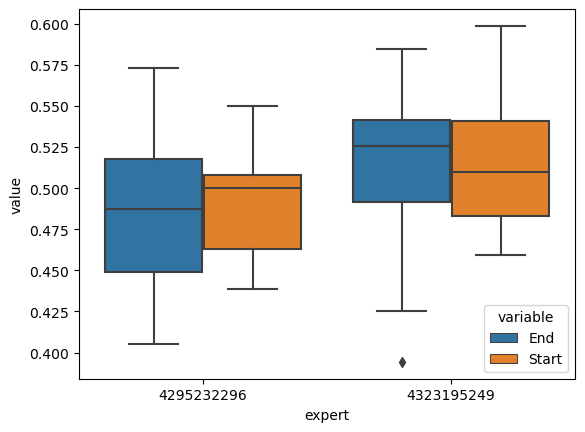

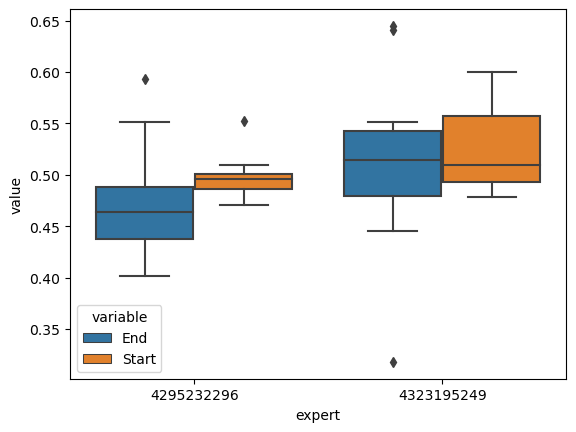

In [155]:
met = get_expert_values("Val", "accurancy_balanced")

plot_expert_values(met[2])
plot_expert_values(met[1])
df_runs

In [156]:
met = get_expert_values("Val", "accurancy_balanced")

In [275]:
def create_expert_metrics(met):
    metrics = {}
    for expert_id in met[0]:
        metrics[expert_id] = []
        for run in met:
            start_metrics = {}
            end_metrics = {}
            for seed_fold, value in run[expert_id].items():
                if "Start" in value:
                    start_metrics[seed_fold] = value["Start"]
                end_metrics[seed_fold] = value["End"]
            if len(start_metrics) == 0:
                start_metrics = end_metrics
            metrics[expert_id].append({
                "Start": start_metrics,
                "End": end_metrics
            })
    return metrics

def get_expert_df(metrics, expert_id, start=False):
    if start:
        df1 = pd.DataFrame([row["Start"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='start')
    df2 = pd.DataFrame([row["End"] for row in metrics[expert_id]]).reset_index().melt(id_vars=['index'], var_name='seed_fold', value_name='end')

    if start:
        df_final = df1
        df_final["end"] = df2["end"]
    else:
        df_final = df2
    df_final = df_final.melt(id_vars=["index", "seed_fold"], var_name="step")

    return df_final

def plot_expert_runs_al(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id, start=True)
    plt.figure()
    f, ax = plt.subplots(figsize=(25, 11))
    sns.boxplot(df, x="index", y="value", hue="step", ax=ax)

def plot_expert_runs_end(metrics, expert_id, step, metrics_name):
    met = get_expert_values(step, metrics_name)
    df = get_expert_df(create_expert_metrics(met), expert_id)
    plt.figure()
    f, ax = plt.subplots(figsize=(25, 11))
    sns.boxplot(df, x="index", y="value", ax=ax)

In [159]:
display(HTML(df_runs.to_html()))

<Figure size 640x480 with 0 Axes>

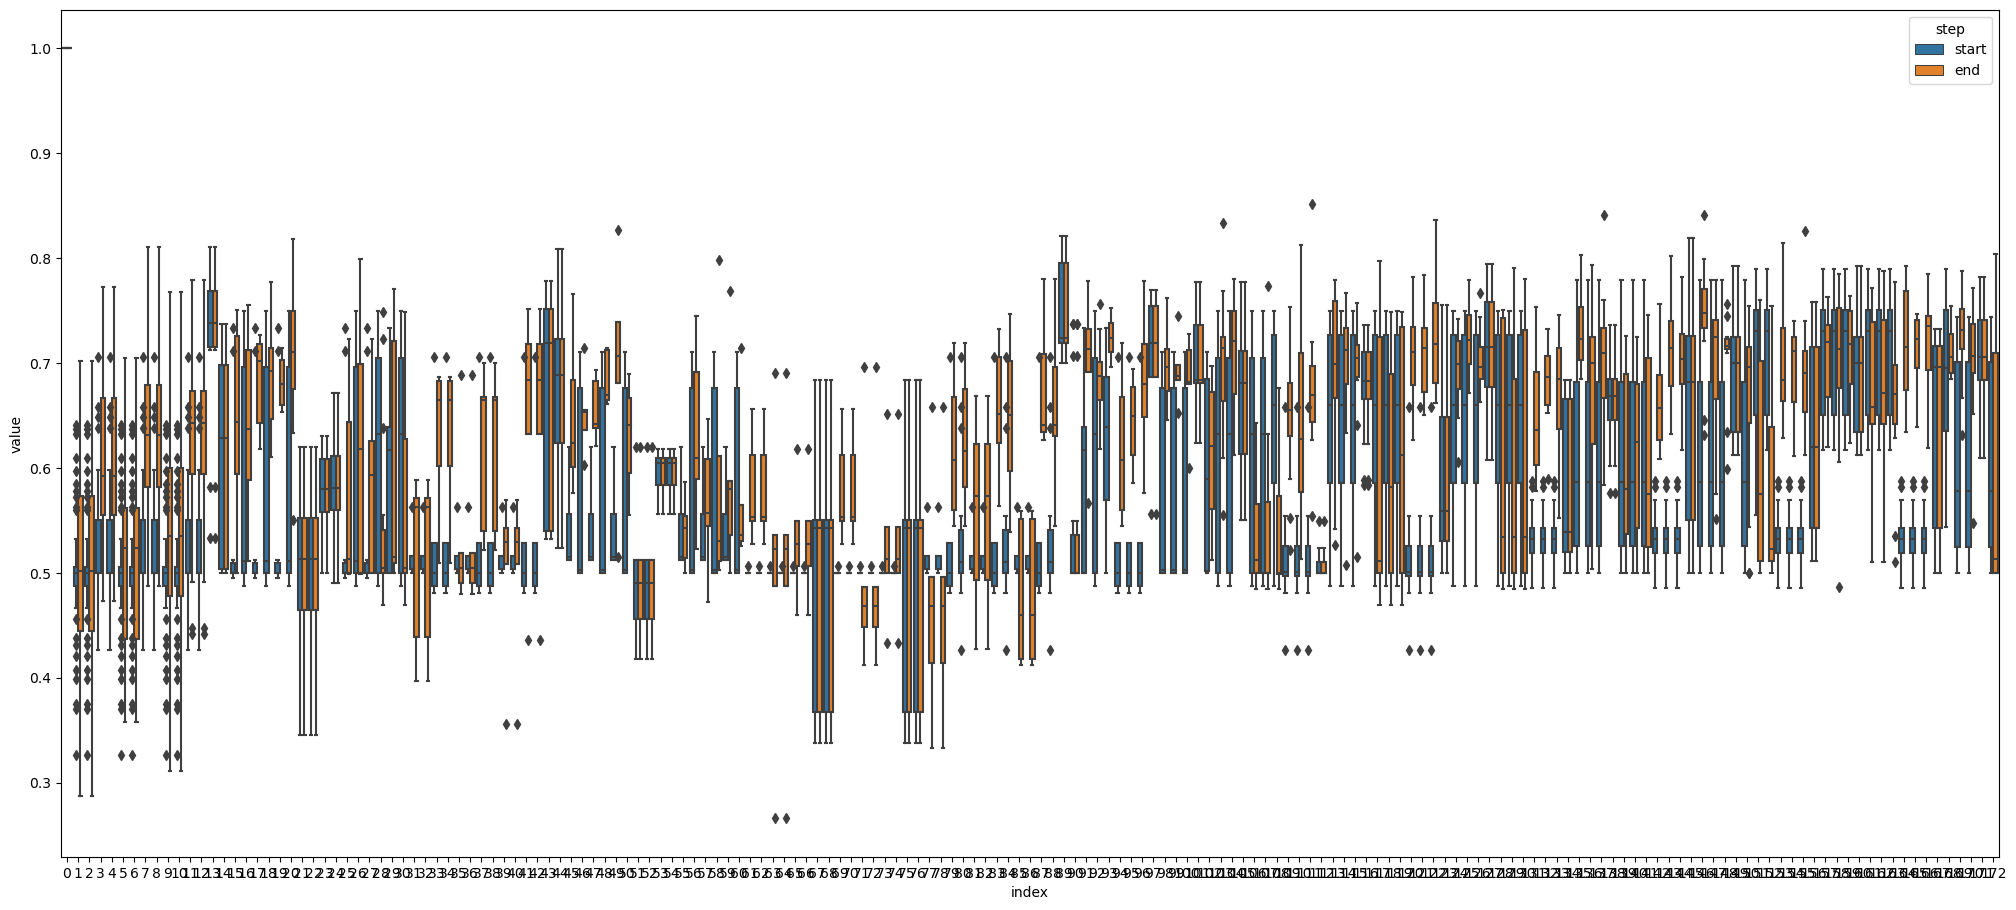

In [369]:
plot_expert_runs_al(metrics, 4323195249, "Test", "accurancy_balanced")

<Figure size 640x480 with 0 Axes>

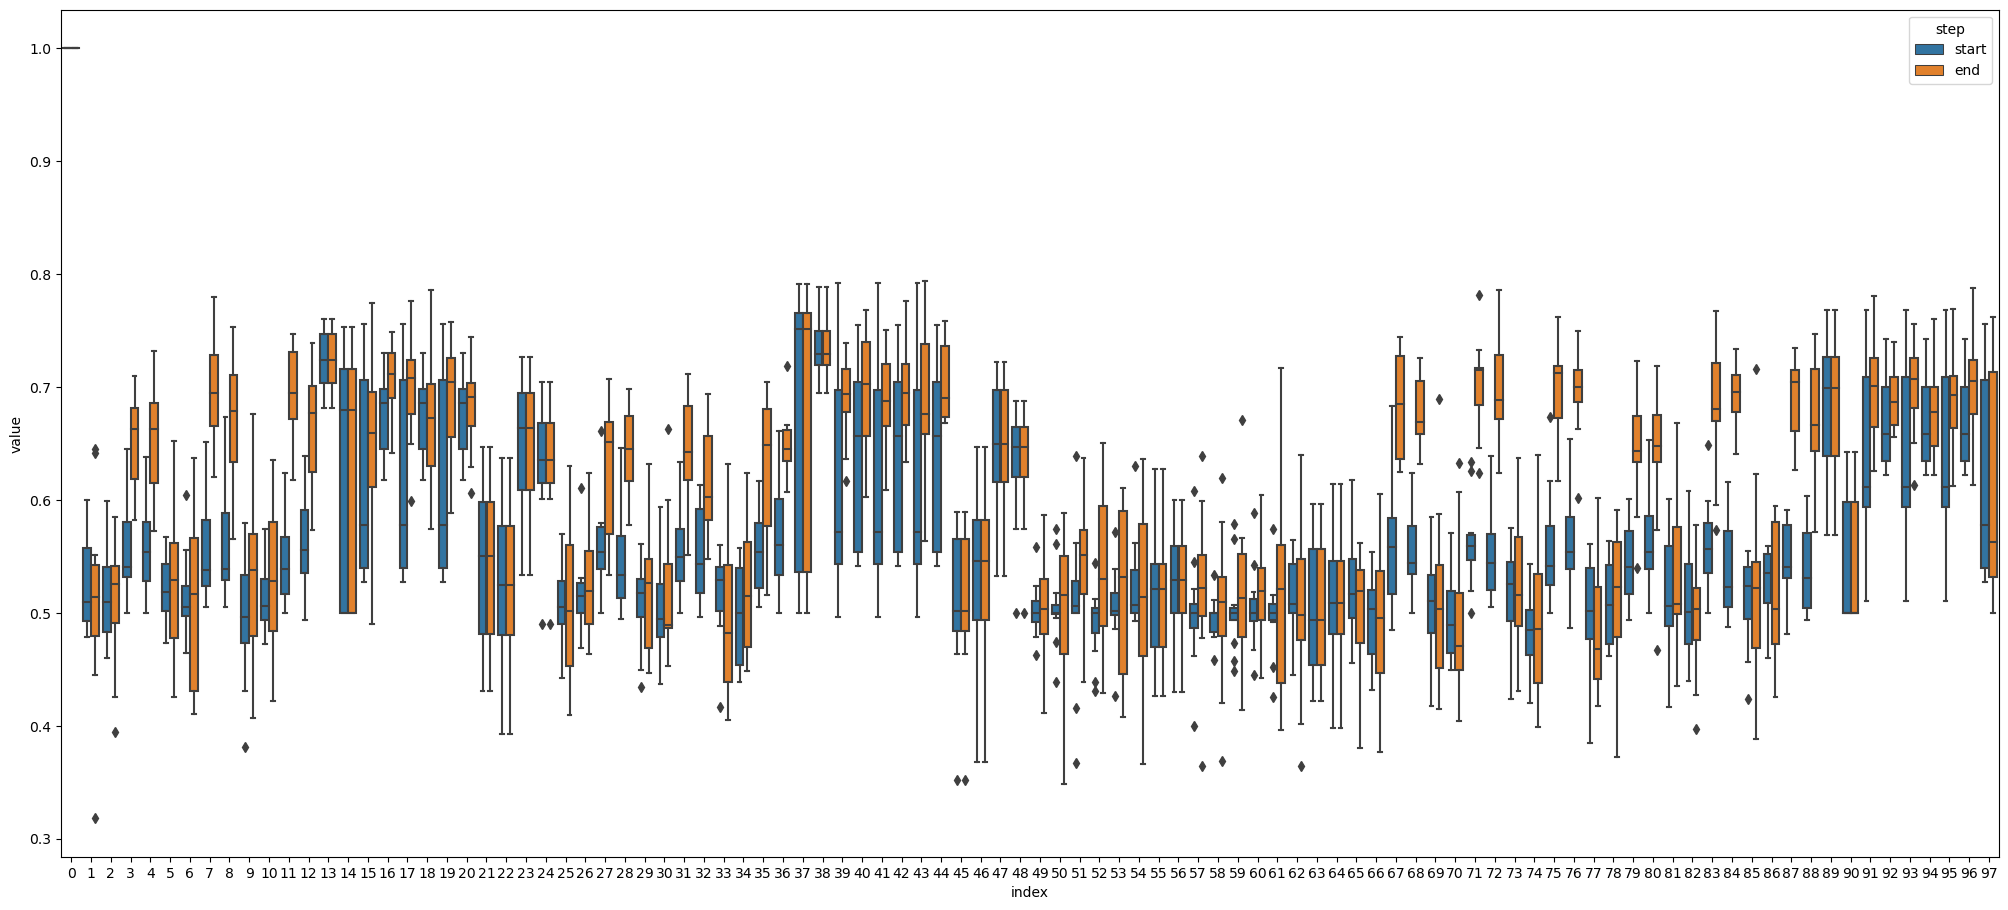

In [161]:
plot_expert_runs_al(metrics, 4323195249, "Val", "accurancy_balanced")

<Figure size 640x480 with 0 Axes>

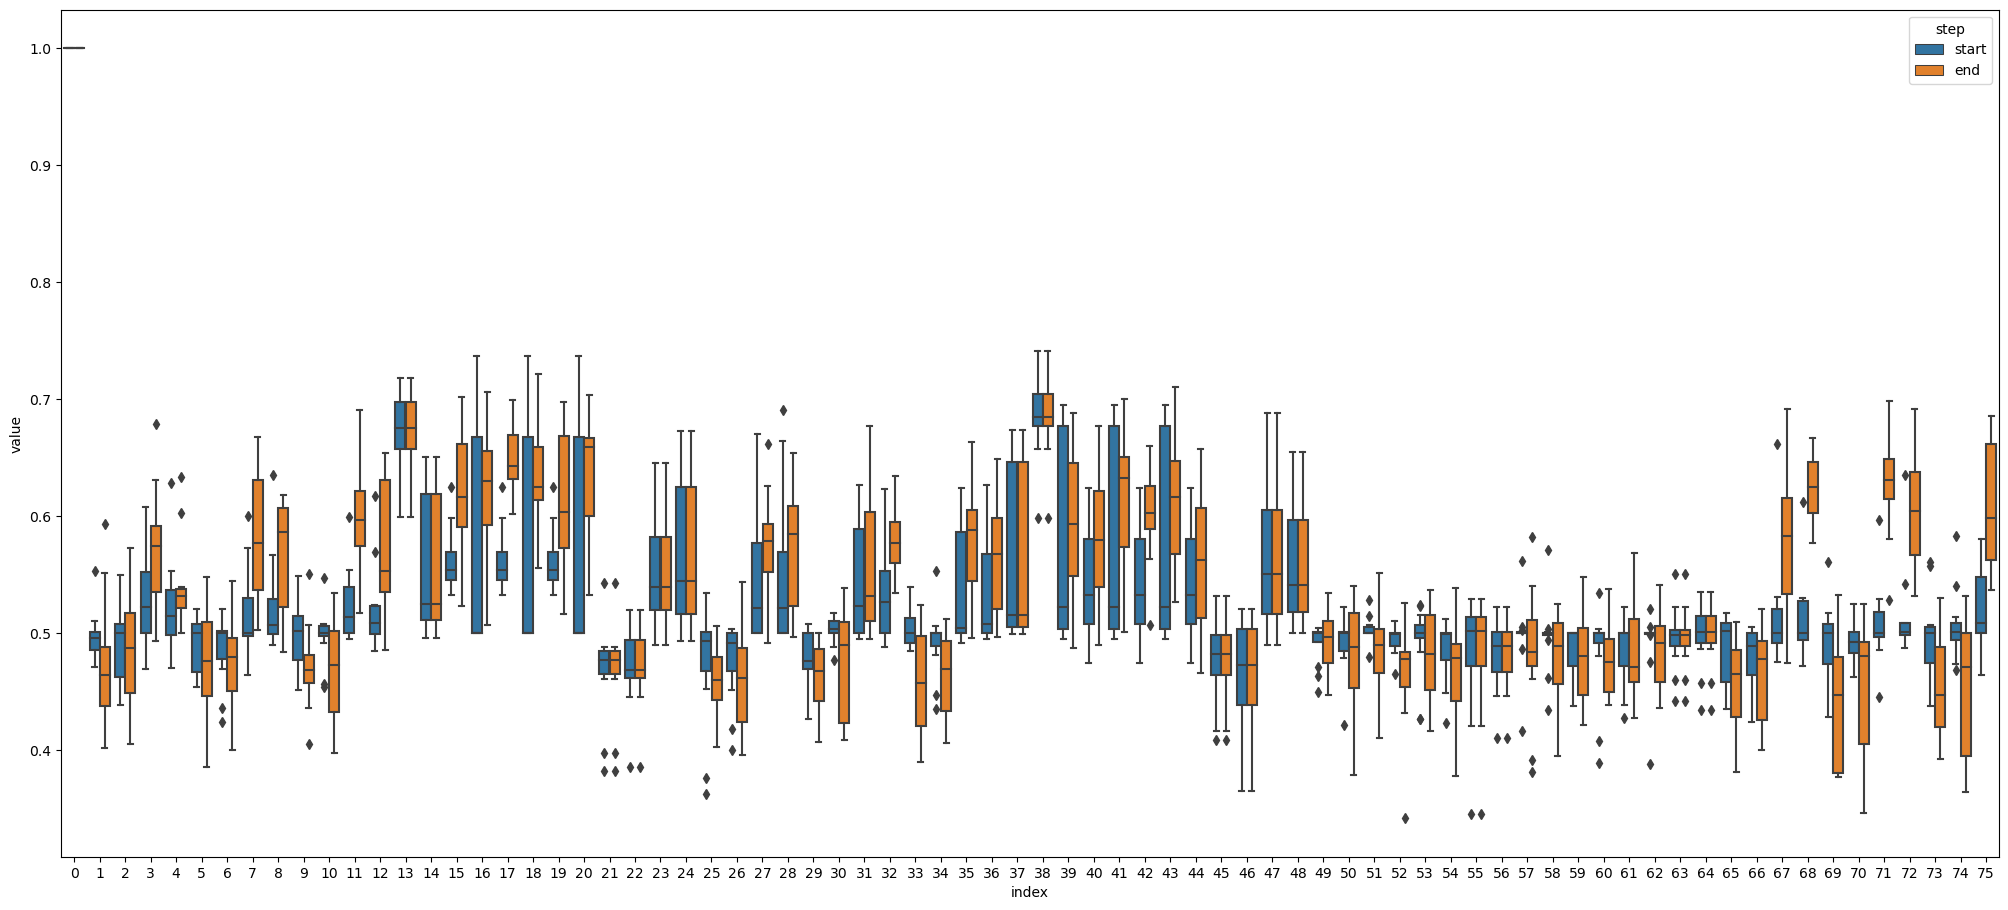

In [1028]:
plot_expert_runs_al(metrics, 4295232296, "Val", "accurancy_balanced")

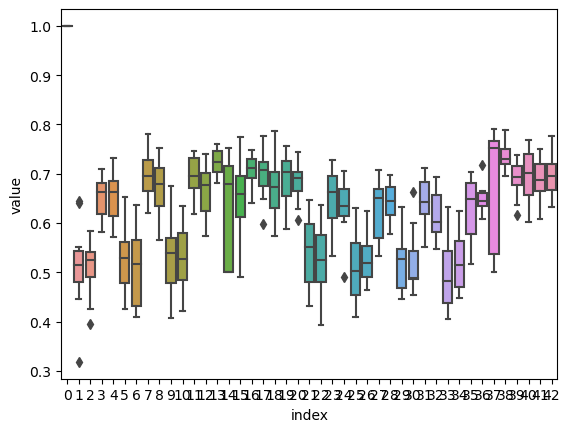

In [486]:
plot_expert_runs_end(metrics, 4323195249, "Val", "accurancy_balanced")

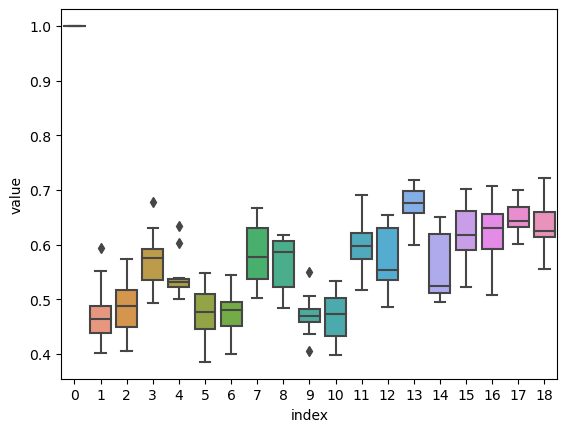

In [987]:
plot_expert_runs_end(metrics, 4295232296, "Val", "accurancy_balanced")

In [523]:
df = pd.DataFrame({"col1": []})
#df["col1"] = df["col1"].astype("category")

s = pd.Series(["MP1"])
s = s.astype("category")

df["col1"] = df["col1"].combine_first(s)

In [1080]:
st = "Metrics_98.pickle"

In [1081]:
st[8:-7]

'98'

In [1090]:
import glob
import os

list_of_files = glob.glob(f'../Metrics_Folder/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
latest_file

'../Metrics_Folder/Metrics_2.pickle'

In [ ]:
"2"